# CSE252C: Homework 1
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Mon, May 4, by 4pm PST.

## Question 1: Warm Up

We will first try SFM using the original implementation from $\mathtt{libviso2}$[8],[9]. We will test on a dataset containing 300 images from one sequence of the KITTI dataset with ground-truth camera poses and camera calibration information. 

Run the SFM algorithm using the following script. You are required to report two error metrics. The error metric for rotation is defined as the mean of Frobenius norm of the difference between the ground-truth rotation matrix and predicted rotation matrix. The error metric for translation is defined as mean of the L2 distance. Both errors will be printed on the screen as you run the code.  **(5 points)**

In [1]:
import os
import sys
# change your base path
os.chdir('./pyviso/') # './'
print(os.getcwd())

/datasets/home/home-02/70/670/y2di/cse252c_hw1/pyviso


In [2]:
import os
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import viso2
import matplotlib.pyplot as plt
from skimage.io import imread
import time

def errorMetric(RPred, RGt, TPred, TGt):
    diffRot = (RPred - RGt)
    diffTrans = (TPred - TGt)
    errorRot = np.sqrt(np.sum(np.multiply(diffRot.reshape(-1), diffRot.reshape(-1))))
    errorTrans = np.sqrt(np.sum(np.multiply(diffTrans.reshape(-1), diffTrans.reshape(-1))))

    return errorRot, errorTrans

if_vis = False # set to True to do the visualization per frame; the images will be saved at '.vis/'. Turn off if you just want the camera poses and errors
if_on_screen = False # if True the visualization per frame is going to be displayed realtime on screen; if False there will be no display, but in both options the images will be saved

# parameter settings (for an example, please download
# dataset_path = '../dataset'
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM' # On the ``ieng6.ucsd.edu`` server
img_dir      = os.path.join(dataset_path, 'sequences/00/image_0')
gt_dir       = os.path.join(dataset_path, 'poses/00.txt')
calibFile    = os.path.join(dataset_path, 'sequences/00/calib.txt')
border       = 50;
gap          = 15;

# Load the camera calibration information
with open(calibFile) as fid:
    calibLines = fid.readlines()
    calibLines = [calibLine.strip() for calibLine in calibLines]

calibInfo = [float(calibStr) for calibStr in calibLines[0].split(' ')[1:]]
# param = {'f': calibInfo[0], 'cu': calibInfo[2], 'cv': calibInfo[6]}

# Load the ground-truth depth and rotation
with open(gt_dir) as fid:
    gtTr = [[float(TrStr) for TrStr in line.strip().split(' ')] for line in fid.readlines()]
gtTr = np.asarray(gtTr).reshape(-1, 3, 4)

# param['height'] = 1.6
# param['pitch']  = -0.08
# param['match'] = {'pre_step_size': 64}
first_frame  = 0
last_frame   = 300
epi = 1e-8

# init visual odometry
params = viso2.Mono_parameters()
params.calib.f = calibInfo[0]
params.calib.cu = calibInfo[2]
params.calib.cv = calibInfo[6]
params.height = 1.6
params.pitch = -0.08


first_frame  = 0
last_frame   = 300

# init transformation matrix array
Tr_total = []
Tr_total_np = []
Tr_total.append(viso2.Matrix_eye(4))
Tr_total_np.append(np.eye(4))

# init viso module
visoMono = viso2.VisualOdometryMono(params)

if if_vis:
    save_path = 'vis'
    os.makedirs(save_path, exist_ok=True)

    # create figure
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(211)
    ax1.axis('off')
    ax2 = plt.subplot(212)
    ax2.set_xticks(np.arange(-100, 100, step=10))
    ax2.set_yticks(np.arange(-500, 500, step=10))
    ax2.axis('equal')
    ax2.grid()
    if if_on_screen:
        plt.ion()
    else:
        plt.ioff()

In [3]:
# for all frames do
if_replace = False
errorTransSum = 0
errorRotSum = 0
errorRot_list = []
errorTrans_list =[]

for frame in range(first_frame, last_frame):
    # 1-based index
    k = frame-first_frame+1

    # read current images
    I = imread(os.path.join(img_dir, '%06d.png'%frame))
    assert(len(I.shape) == 2) # should be grayscale

    # compute egomotion
    process_result = visoMono.process_frame(I, if_replace)
    Tr = visoMono.getMotion()
    matrixer = viso2.Matrix(Tr)
    Tr_np = np.zeros((4, 4))
    Tr.toNumpy(Tr_np) # so awkward...

    # accumulate egomotion, starting with second frame
    if k > 1:
        if process_result is False:
            if_replace = True
            Tr_total.append(Tr_total[-1])
            Tr_total_np.append(Tr_total_np[-1])
        else:
            if_replace = False
            Tr_total.append(Tr_total[-1] * viso2.Matrix_inv(Tr))
            Tr_total_np.append(Tr_total_np[-1] @ np.linalg.inv(Tr_np)) # should be the same
            print(Tr_total_np[-1])

    # output statistics
    num_matches = visoMono.getNumberOfMatches()
    num_inliers = visoMono.getNumberOfInliers()
    matches = visoMono.getMatches()
    matches_np = np.empty([4, matches.size()])

    for i,m in enumerate(matches):
        matches_np[:, i] = (m.u1p, m.v1p, m.u1c, m.v1c)

    if if_vis:
        # update image
        ax1.clear()
        ax1.imshow(I, cmap='gray', vmin=0, vmax=255)
        if num_matches != 0:
            for n in range(num_matches):
                ax1.plot([matches_np[0, n], matches_np[2, n]], [matches_np[1, n], matches_np[3, n]])
        ax1.set_title('Frame %d'%frame)

        # update trajectory
        if k > 1:
            ax2.plot([Tr_total_np[k-2][0, 3], Tr_total_np[k-1][0, 3]], \
                [Tr_total_np[k-2][2, 3], Tr_total_np[k-1][2, 3]], 'b.-', linewidth=1)
            ax2.plot([gtTr[k-2][0, 3], gtTr[k-1][0, 3]], \
                [gtTr[k-2][2, 3], gtTr[k-1][2, 3]], 'r.-', linewidth=1)
        ax2.set_title('Blue: estimated trajectory; Red: ground truth trejectory')

        plt.draw()

    # Compute rotation
    Rpred_p = Tr_total_np[k-2][0:3, 0:3]
    Rpred_c = Tr_total_np[k-1][0:3, 0:3]
    Rpred = Rpred_c.transpose() @ Rpred_p
    Rgt_p = np.squeeze(gtTr[k-2, 0:3, 0:3])
    Rgt_c = np.squeeze(gtTr[k-1, 0:3, 0:3])
    Rgt = Rgt_c.transpose() @ Rgt_p
    # Compute translation
    Tpred_p = Tr_total_np[k-2][0:3, 3:4]
    Tpred_c = Tr_total_np[k-1][0:3, 3:4]
    Tpred = Tpred_c - Tpred_p
    Tgt_p = gtTr[k-2, 0:3, 3:4]
    Tgt_c = gtTr[k-1, 0:3, 3:4]
    Tgt = Tgt_c - Tgt_p
    # Compute errors
    errorRot, errorTrans = errorMetric(Rpred, Rgt, Tpred, Tgt)
    errorRotSum = errorRotSum + errorRot
    errorTransSum = errorTransSum + errorTrans
    # errorRot_list.append(errorRot)
    # errorTrans_list.append(errorTrans)
    print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1+epi)))
    print('Mean Error Translation: %.5f'%(errorTransSum / (k-1+epi)))



    print('== [Result] Frame: %d, Matches %d, Inliers: %.2f'%(frame, num_matches, 100*num_inliers/(num_matches+1e-8)))

    if if_vis:
        # input('Paused; Press Enter to continue') # Option 1: Manually pause and resume
        if if_on_screen:
            plt.pause(0.1) # Or Option 2: enable to this to auto pause for a while after daring to enable animation in case of a delay in drawing
        vis_path = os.path.join(save_path, 'frame%03d.jpg'%frame)
        fig.savefig(vis_path)
        print('Saved at %s'%vis_path)
        
        if frame % 50 == 0 or frame == last_frame-1:
            plt.figure(figsize=(10, 15))
            plt.imshow(plt.imread(vis_path))
            plt.axis('off')
            plt.show()


# input('Press Enter to exit')

Mean Error Rotation: 6947558.55240
Mean Error Translation: 9718750861.05217
== [Result] Frame: 0, Matches 0, Inliers: 0.00
[[ 1.     -0.0027 -0.0031 -0.0032]
 [ 0.0027  1.     -0.0026  0.0011]
 [ 0.0031  0.0026  1.      0.4828]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07468
Mean Error Translation: 97.56708
== [Result] Frame: 1, Matches 320, Inliers: 86.87
[[ 1.     -0.0022 -0.0078 -0.0051]
 [ 0.0022  1.     -0.0041 -0.0018]
 [ 0.0078  0.0041  1.      0.9579]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03918
Mean Error Translation: 48.97651
== [Result] Frame: 2, Matches 325, Inliers: 81.23
[[ 0.9999 -0.0057 -0.014   0.0024]
 [ 0.0056  1.     -0.0053 -0.0075]
 [ 0.014   0.0052  0.9999  1.4471]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02883
Mean Error Translation: 32.77574
== [Result] Frame: 3, Matches 329, Inliers: 82.67
[[ 0.9998 -0.0058 -0.0197 -0.0071]
 [ 0.0057  1.     -0.006  -0.0118]
 [ 0.0197  0.0059  0.9998  1.9428]
 [ 0.      0.

[[ 0.9981 -0.0043 -0.0621 -1.1303]
 [ 0.0039  1.     -0.0077 -0.2411]
 [ 0.0621  0.0074  0.998  19.9495]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00513
Mean Error Translation: 3.23366
== [Result] Frame: 33, Matches 280, Inliers: 76.43
[[ 0.9981 -0.0046 -0.0622 -1.175 ]
 [ 0.0045  1.     -0.0026 -0.2516]
 [ 0.0622  0.0023  0.9981 20.6084]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00503
Mean Error Translation: 3.14788
== [Result] Frame: 34, Matches 282, Inliers: 75.18
[[ 0.998  -0.0077 -0.0633 -1.22  ]
 [ 0.0078  1.      0.0007 -0.2615]
 [ 0.0633 -0.0011  0.998  21.3241]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00492
Mean Error Translation: 3.06549
== [Result] Frame: 35, Matches 277, Inliers: 75.81
[[ 0.9977 -0.0166 -0.0652 -1.2517]
 [ 0.0166  0.9999  0.0003 -0.272 ]
 [ 0.0652 -0.0014  0.9979 22.0132]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00484
Mean Error Translation: 2.98841
== [Result] Frame: 36, Matches 276, Inl

[[ 0.9949 -0.0259 -0.0978 -2.9719]
 [ 0.025   0.9996 -0.0111 -0.5592]
 [ 0.098   0.0086  0.9951 42.8733]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00346
Mean Error Translation: 1.76379
== [Result] Frame: 66, Matches 294, Inliers: 80.61
[[ 0.9949 -0.0211 -0.0987 -3.0457]
 [ 0.0202  0.9997 -0.0103 -0.5749]
 [ 0.0989  0.0082  0.9951 43.5263]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00342
Mean Error Translation: 1.74131
== [Result] Frame: 67, Matches 295, Inliers: 80.34
[[ 0.9948 -0.0178 -0.1    -3.1204]
 [ 0.0171  0.9998 -0.0081 -0.5924]
 [ 0.1001  0.0064  0.995  44.2142]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00339
Mean Error Translation: 1.71881
== [Result] Frame: 68, Matches 306, Inliers: 81.70
[[ 0.9949 -0.0128 -0.1001 -3.2052]
 [ 0.0122  0.9999 -0.0066 -0.6103]
 [ 0.1001  0.0054  0.995  44.8654]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00339
Mean Error Translation: 1.69727
== [Result] Frame: 69, Matches 297, Inl

[[ 0.9917 -0.0391  0.1222 -4.3659]
 [ 0.0391  0.9992  0.0029 -0.9481]
 [-0.1223  0.0019  0.9925 59.5015]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00321
Mean Error Translation: 1.22141
== [Result] Frame: 100, Matches 332, Inliers: 84.04
[[ 0.9851 -0.0388  0.1675 -4.2895]
 [ 0.0385  0.9992  0.0049 -0.9483]
 [-0.1676  0.0017  0.9859 59.8246]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00319
Mean Error Translation: 1.21033
== [Result] Frame: 101, Matches 330, Inliers: 83.64
[[ 0.9759 -0.0385  0.2149 -4.183 ]
 [ 0.0383  0.9993  0.0048 -0.9526]
 [-0.2149  0.0035  0.9766 60.1273]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00319
Mean Error Translation: 1.19938
== [Result] Frame: 102, Matches 336, Inliers: 87.20
[[ 0.9631 -0.0423  0.2659 -4.0492]
 [ 0.0427  0.9991  0.0045 -0.9628]
 [-0.2658  0.007   0.964  60.4066]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00322
Mean Error Translation: 1.18879
== [Result] Frame: 103, Matches 342,

[[ 0.1359 -0.0532  0.9893  9.3034]
 [ 0.0829  0.9957  0.0422 -0.4597]
 [-0.9872  0.0763  0.1398 65.2358]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00319
Mean Error Translation: 0.96494
== [Result] Frame: 133, Matches 321, Inliers: 83.49
[[ 0.13   -0.0526  0.9901  9.6952]
 [ 0.0837  0.9956  0.0419 -0.4443]
 [-0.988   0.0774  0.1338 65.2898]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00317
Mean Error Translation: 0.95895
== [Result] Frame: 134, Matches 321, Inliers: 83.80
[[ 0.1241 -0.0519  0.9909 10.1025]
 [ 0.0839  0.9956  0.0416 -0.4315]
 [-0.9887  0.0779  0.1279 65.3436]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00316
Mean Error Translation: 0.95306
== [Result] Frame: 135, Matches 312, Inliers: 81.09
[[ 0.119  -0.0511  0.9916 10.5186]
 [ 0.0846  0.9956  0.0411 -0.4149]
 [-0.9893  0.079   0.1228 65.3877]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00315
Mean Error Translation: 0.94732
== [Result] Frame: 136, Matches 306,

[[ 0.1151 -0.0515  0.992  28.3059]
 [ 0.0683  0.9967  0.0438  0.1369]
 [-0.991   0.0627  0.1182 67.8186]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00295
Mean Error Translation: 0.81214
== [Result] Frame: 166, Matches 321, Inliers: 75.70
[[ 0.1022 -0.0503  0.9935 28.948 ]
 [ 0.0616  0.9971  0.0441  0.1501]
 [-0.9929  0.0567  0.105  67.9244]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00300
Mean Error Translation: 0.80845
== [Result] Frame: 167, Matches 312, Inliers: 69.23
[[ 0.0936 -0.0511  0.9943 29.9976]
 [ 0.064   0.9969  0.0452  0.1894]
 [-0.9936  0.0594  0.0966 67.9925]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00300
Mean Error Translation: 0.80527
== [Result] Frame: 168, Matches 317, Inliers: 76.66
[[ 0.0809 -0.0526  0.9953 30.8604]
 [ 0.059   0.9971  0.0479  0.2009]
 [-0.995   0.0549  0.0838 68.0992]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00301
Mean Error Translation: 0.80136
== [Result] Frame: 169, Matches 316,

[[ 0.3068 -0.0512  0.9504 50.7564]
 [ 0.0684  0.9972  0.0316  0.8653]
 [-0.9493  0.0554  0.3094 68.9989]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00287
Mean Error Translation: 0.72116
== [Result] Frame: 199, Matches 331, Inliers: 84.29
[[ 0.3558 -0.0516  0.9331 51.0811]
 [ 0.0655  0.9974  0.0302  0.868 ]
 [-0.9323  0.0504  0.3583 69.1622]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00287
Mean Error Translation: 0.71831
== [Result] Frame: 200, Matches 332, Inliers: 83.73
[[ 0.4065 -0.0498  0.9123 51.4056]
 [ 0.0638  0.9976  0.026   0.874 ]
 [-0.9114  0.0476  0.4087 69.3567]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00287
Mean Error Translation: 0.71542
== [Result] Frame: 201, Matches 352, Inliers: 83.52
[[ 0.4606 -0.0481  0.8863 51.7181]
 [ 0.066   0.9976  0.0198  0.8761]
 [-0.8852  0.0494  0.4627 69.5668]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00288
Mean Error Translation: 0.71254
== [Result] Frame: 202, Matches 343,

[[ 0.982   0.      0.1887 55.0742]
 [ 0.0053  0.9996 -0.0277  0.4544]
 [-0.1886  0.0282  0.9816 81.2988]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00286
Mean Error Translation: 0.63818
== [Result] Frame: 232, Matches 308, Inliers: 82.79
[[ 0.9812 -0.0027  0.1928 55.168 ]
 [ 0.0081  0.9996 -0.0273  0.4384]
 [-0.1927  0.0284  0.9808 81.8244]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00286
Mean Error Translation: 0.63600
== [Result] Frame: 233, Matches 313, Inliers: 80.83
[[ 0.981  -0.0057  0.1937 55.3231]
 [ 0.0118  0.9995 -0.0305  0.4074]
 [-0.1935  0.0322  0.9806 82.615 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00285
Mean Error Translation: 0.63394
== [Result] Frame: 234, Matches 309, Inliers: 84.47
[[ 0.981  -0.0065  0.1941 55.4438]
 [ 0.014   0.9992 -0.0377  0.3794]
 [-0.1937  0.0397  0.9803 83.2728]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00285
Mean Error Translation: 0.63147
== [Result] Frame: 235, Matches 301,

[[  0.9814   0.0218   0.1909  58.9689]
 [ -0.012    0.9986  -0.0521  -0.6745]
 [ -0.1918   0.0488   0.9802 104.2734]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00277
Mean Error Translation: 0.58400
== [Result] Frame: 265, Matches 265, Inliers: 80.38
[[  0.9815   0.0199   0.1902  59.1297]
 [ -0.0083   0.9981  -0.0611  -0.7217]
 [ -0.1911   0.0584   0.9798 105.0952]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00278
Mean Error Translation: 0.58202
== [Result] Frame: 266, Matches 271, Inliers: 74.91
[[  0.9817   0.018    0.1897  59.3077]
 [ -0.0082   0.9986  -0.0522  -0.7708]
 [ -0.1904   0.0497   0.9804 106.0303]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00278
Mean Error Translation: 0.58028
== [Result] Frame: 267, Matches 279, Inliers: 77.42
[[  0.9819   0.0123   0.1888  59.4236]
 [ -0.0064   0.9995  -0.0317  -0.8046]
 [ -0.1891   0.0299   0.9815 106.6409]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00279
Mean

[[  0.9966   0.0348   0.0749  62.5405]
 [ -0.0307   0.998   -0.0544  -2.0325]
 [ -0.0767   0.0519   0.9957 128.6504]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00278
Mean Error Translation: 0.54051
== [Result] Frame: 296, Matches 314, Inliers: 85.67
[[  0.9971   0.0352   0.0672  62.5694]
 [ -0.0317   0.9981  -0.0522  -2.0642]
 [ -0.0689   0.0499   0.9964 129.2509]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00278
Mean Error Translation: 0.53945
== [Result] Frame: 297, Matches 301, Inliers: 89.04
[[  0.9975   0.0378   0.0591  62.6019]
 [ -0.0352   0.9984  -0.0453  -2.1015]
 [ -0.0607   0.0431   0.9972 129.8692]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00277
Mean Error Translation: 0.53835
== [Result] Frame: 298, Matches 292, Inliers: 81.16
[[  0.9979   0.0406   0.0511  62.6225]
 [ -0.0386   0.9985  -0.0397  -2.1363]
 [ -0.0526   0.0377   0.9979 130.5054]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00277
Mean

1. Report the final rotation and translation error. **(2 points)**

The final errors are:
1. Rotation: 0.00277
2. Translation: 0.53721

Then answer the questions below

2. In $\mathtt{libviso2}$, the feature points are "bucketed" ($\mathtt{src/matcher.cpp: Line 285 - 326}$), which means in a certain area of region, the number of detected keypoint pairs should be within certain bounds. Why?  **(3 points)**

It is due to the fact that nearby features in the original image should also be relatively close to each other in the other image. If the number of original features in a fixed bucket is within a bound, then bucket containing the corresponding features should also contain a bounded number of features.

3. We have run SFM on a single camera, which means the scale of translation is unknown. However, as you may have observed, the predicted trajectory is still somehow similar to the ground-truth trajectory. How does $\mathtt{libviso2}$ handle this ambiguity ($\mathtt{viso\_mono.cpp: Line 245}$)?  **(5 points)**

libviso2 first estimates the height of the camera of each frame based on the x-plane, and then find the height that is the most likely from the estimates, based on a Gaussian distribution. The center of the Gaussian is the estimate for the frame, and the likelihood is the sum of the density of the heights evaluated with this gaussian. The estimate that has the largest sum of probability is used as the best estimate. 

Then libviso2 scales the translation by the ratio of true height / best estimate of height.

4. Briefly explain the RANSAC algorithm used in $\mathtt{libviso2}$ ($\mathtt{viso\_mono.cpp: Line 113 - 129}$).  **(5 points)**

It consists of the following steps:

For each iteration until a threshold
1. Draw 8 random feature points from the N points;
2. Estimate the fundamental matrix according to the 8 correspondance pairs;
3. Compute the number of inliers based on the fundamental matrix computed in step 2;
4. Update the number of inliers if there is an improvement.

## Question 2: Using SIFT [4] for SFM

In the second task, you are required to use keypoints and feature descriptors from SIFT for SFM. The SIFT implementation can be found in directory $\mathtt{SIFT}$. 

(A) Go to $\mathtt{SIFT}$ directory and run $\mathtt{runSIFT.py}$ (e.g. `python runSIFT.py --input /datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/image_0/`). You will save the detected keypoints and feature descriptors under the directory $\mathtt{SIFT}$. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable should be a $130 \times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $130$-dimensional feature vector, the first two dimensions are the location of the keypoints (column number first and then row number) on the image plane and the last $128$ dimensions are the feature descriptor. 

(B) Run the following script

In [4]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SIFT'
runFeature.runSFM(dataset_path, feature_dir )

/datasets/home/home-02/70/670/y2di/cse252c_hw1/pyviso/runFeature.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1)))
/datasets/home/home-02/70/670/y2di/cse252c_hw1/pyviso/runFeature.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Translation: %.5f'%(errorTransSum / (k-1)))


Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00
[[ 1.     -0.0028 -0.0035 -0.0003]
 [ 0.0028  1.     -0.0022 -0.0034]
 [ 0.0035  0.0022  1.      0.4718]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07478
Mean Error Translation: 97.57803
== [Result] Frame: 1, Matches 282, Inliers: 81.21
[[ 1.     -0.0015 -0.0074 -0.0079]
 [ 0.0015  1.     -0.0036 -0.0068]
 [ 0.0074  0.0036  1.      0.9191]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03881
Mean Error Translation: 48.99547
== [Result] Frame: 2, Matches 281, Inliers: 74.38
[[ 0.9999 -0.0022 -0.0118 -0.0123]
 [ 0.0021  1.     -0.0051 -0.0093]
 [ 0.0118  0.0051  0.9999  1.3818]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02713
Mean Error Translation: 32.79668
== [Result] Frame: 3, Matches 292, Inliers: 77.40
[[ 0.9998 -0.002  -0.0173 -0.0196]
 [ 0.0019  1.     -0.0058 -0.0135]
 [ 0.0173  0.0057  0.9998  1.8655]
 [ 0.      0.      0.      1.    ]]


[[ 0.9982 -0.0019 -0.0598 -1.0345]
 [ 0.0015  1.     -0.0056 -0.2166]
 [ 0.0598  0.0055  0.9982 19.6128]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00507
Mean Error Translation: 3.24390
== [Result] Frame: 33, Matches 229, Inliers: 69.43
[[ 0.9981 -0.0066 -0.0609 -1.0648]
 [ 0.0066  1.     -0.0004 -0.2277]
 [ 0.0609 -0.      0.9981 20.2741]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00506
Mean Error Translation: 3.15776
== [Result] Frame: 34, Matches 233, Inliers: 68.67
[[ 0.998  -0.0125 -0.0627 -1.0959]
 [ 0.0127  0.9999  0.0032 -0.239 ]
 [ 0.0626 -0.004   0.998  20.9485]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00503
Mean Error Translation: 3.07627
== [Result] Frame: 35, Matches 239, Inliers: 64.85
[[ 0.9978 -0.0175 -0.0634 -1.135 ]
 [ 0.0177  0.9998  0.0026 -0.2517]
 [ 0.0633 -0.0037  0.998  21.6054]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00500
Mean Error Translation: 2.99979
== [Result] Frame: 36, Matches 237, Inl

[[ 0.9954 -0.0272 -0.0922 -2.7252]
 [ 0.0269  0.9996 -0.0041 -0.4784]
 [ 0.0923  0.0016  0.9957 41.9187]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00343
Mean Error Translation: 1.77835
== [Result] Frame: 66, Matches 234, Inliers: 71.79
[[ 0.9952 -0.0245 -0.0946 -2.7753]
 [ 0.0243  0.9997 -0.0034 -0.4898]
 [ 0.0947  0.001   0.9955 42.5477]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00344
Mean Error Translation: 1.75603
== [Result] Frame: 67, Matches 233, Inliers: 72.96
[[ 0.9951 -0.0227 -0.0962 -2.8351]
 [ 0.0227  0.9997 -0.0012 -0.5021]
 [ 0.0962 -0.001   0.9954 43.1771]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00343
Mean Error Translation: 1.73418
== [Result] Frame: 68, Matches 242, Inliers: 75.62
[[ 0.995  -0.0209 -0.0977 -2.8992]
 [ 0.0211  0.9998  0.0002 -0.513 ]
 [ 0.0977 -0.0022  0.9952 43.8289]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00340
Mean Error Translation: 1.71241
== [Result] Frame: 69, Matches 251, Inl

[[ 0.9946 -0.0211  0.1013 -4.1482]
 [ 0.0204  0.9998  0.0074 -0.7474]
 [-0.1014 -0.0053  0.9948 58.103 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00302
Mean Error Translation: 1.24366
== [Result] Frame: 99, Matches 315, Inliers: 85.71
[[ 0.9896 -0.0202  0.1425 -4.0814]
 [ 0.0191  0.9998  0.0088 -0.7503]
 [-0.1427 -0.006   0.9898 58.4264]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00301
Mean Error Translation: 1.23232
== [Result] Frame: 100, Matches 311, Inliers: 85.53
[[ 0.982  -0.0197  0.1877 -3.9998]
 [ 0.0181  0.9998  0.0104 -0.7559]
 [-0.1878 -0.0068  0.9822 58.7461]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00300
Mean Error Translation: 1.22113
== [Result] Frame: 101, Matches 304, Inliers: 84.21
[[ 0.9715 -0.0177  0.2365 -3.9014]
 [ 0.0158  0.9998  0.0097 -0.7608]
 [-0.2366 -0.0057  0.9716 59.0497]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00299
Mean Error Translation: 1.21009
== [Result] Frame: 102, Matches 296, 

[[ 0.0953 -0.0148  0.9953 13.5049]
 [ 0.0391  0.9992  0.0111 -0.6739]
 [-0.9947  0.0378  0.0958 64.2299]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00283
Mean Error Translation: 1.01640
== [Result] Frame: 132, Matches 296, Inliers: 66.55
[[ 0.0876 -0.0142  0.9961 13.8883]
 [ 0.0411  0.9991  0.0106 -0.6703]
 [-0.9953  0.04    0.0881 64.2582]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00282
Mean Error Translation: 1.00988
== [Result] Frame: 133, Matches 299, Inliers: 71.24
[[ 0.082  -0.0135  0.9965 14.2854]
 [ 0.0424  0.9991  0.01   -0.6658]
 [-0.9957  0.0414  0.0825 64.2879]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00281
Mean Error Translation: 1.00347
== [Result] Frame: 134, Matches 299, Inliers: 69.23
[[ 0.0766 -0.0123  0.997  14.6973]
 [ 0.0435  0.999   0.009  -0.6627]
 [-0.9961  0.0427  0.0771 64.3145]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00279
Mean Error Translation: 0.99717
== [Result] Frame: 135, Matches 301,

[[ 0.0808 -0.0146  0.9966 31.7231]
 [ 0.0388  0.9992  0.0115 -0.6718]
 [-0.996   0.0378  0.0813 65.719 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00260
Mean Error Translation: 0.85102
== [Result] Frame: 165, Matches 316, Inliers: 71.84
[[ 0.0724 -0.0134  0.9973 32.4165]
 [ 0.039   0.9992  0.0106 -0.6715]
 [-0.9966  0.0381  0.0728 65.7671]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00259
Mean Error Translation: 0.84661
== [Result] Frame: 166, Matches 307, Inliers: 66.12
[[ 0.0627 -0.0131  0.9979 33.2461]
 [ 0.0394  0.9992  0.0107 -0.6721]
 [-0.9973  0.0386  0.0631 65.8167]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00258
Mean Error Translation: 0.84192
== [Result] Frame: 167, Matches 294, Inliers: 66.67
[[ 0.053  -0.0144  0.9985 33.9155]
 [ 0.0404  0.9991  0.0123 -0.676 ]
 [-0.9978  0.0397  0.0535 65.8468]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00257
Mean Error Translation: 0.83772
== [Result] Frame: 168, Matches 292,

[[ 0.2208 -0.0111  0.9753 52.7017]
 [ 0.0473  0.9989  0.0007 -0.6956]
 [-0.9742  0.0459  0.2211 65.9317]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00249
Mean Error Translation: 0.74383
== [Result] Frame: 198, Matches 267, Inliers: 75.28
[[ 0.268  -0.0137  0.9633 53.0497]
 [ 0.043   0.9991  0.0023 -0.7009]
 [-0.9625  0.0408  0.2683 66.0589]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00249
Mean Error Translation: 0.74085
== [Result] Frame: 199, Matches 262, Inliers: 70.99
[[ 0.3181 -0.0147  0.9479 53.3928]
 [ 0.0397  0.9992  0.0022 -0.7077]
 [-0.9472  0.0369  0.3184 66.2072]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00248
Mean Error Translation: 0.73780
== [Result] Frame: 200, Matches 271, Inliers: 70.11
[[ 0.3722 -0.0157  0.928  53.7253]
 [ 0.0411  0.9992  0.0004 -0.7179]
 [-0.9273  0.038   0.3725 66.3636]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00248
Mean Error Translation: 0.73479
== [Result] Frame: 201, Matches 271,

[[ 0.9803  0.0092  0.1974 57.8618]
 [-0.0029  0.9995 -0.0321 -1.2294]
 [-0.1976  0.0309  0.9798 78.567 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00248
Mean Error Translation: 0.65568
== [Result] Frame: 231, Matches 213, Inliers: 76.53
[[ 0.9794  0.0078  0.2018 57.9844]
 [-0.0023  0.9996 -0.0275 -1.2535]
 [-0.2019  0.0265  0.979  79.181 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00248
Mean Error Translation: 0.65304
== [Result] Frame: 232, Matches 219, Inliers: 80.37
[[ 0.9786  0.0049  0.2055 58.1094]
 [ 0.0006  0.9996 -0.0268 -1.2756]
 [-0.2055  0.0264  0.9783 79.8046]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00248
Mean Error Translation: 0.65043
== [Result] Frame: 233, Matches 228, Inliers: 82.89
[[ 0.9781  0.0053  0.208  58.2529]
 [ 0.0009  0.9996 -0.0296 -1.314 ]
 [-0.208   0.0292  0.9777 80.6132]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00250
Mean Error Translation: 0.64840
== [Result] Frame: 234, Matches 241,

[[  0.98     0.0189   0.1982  62.7493]
 [ -0.012    0.9993  -0.0363  -2.4346]
 [ -0.1988   0.0332   0.9795 104.8197]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00243
Mean Error Translation: 0.60030
== [Result] Frame: 264, Matches 192, Inliers: 84.90
[[  0.9802   0.0122   0.1976  62.9377]
 [ -0.0022   0.9987  -0.0508  -2.4825]
 [ -0.198    0.0493   0.979  105.6756]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00244
Mean Error Translation: 0.59824
== [Result] Frame: 265, Matches 213, Inliers: 84.51
[[  0.9802   0.0103   0.1975  63.1534]
 [  0.0015   0.9982  -0.0598  -2.5438]
 [ -0.1978   0.0589   0.9785 106.7357]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00244
Mean Error Translation: 0.59694
== [Result] Frame: 266, Matches 207, Inliers: 84.54
[[  0.9803   0.0094   0.1974  63.3328]
 [  0.0007   0.9987  -0.0508  -2.5951]
 [ -0.1977   0.0499   0.979  107.6931]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00246
Mean

[[  0.9949   0.0353   0.0945  67.11  ]
 [ -0.0309   0.9984  -0.0474  -3.9108]
 [ -0.096    0.0442   0.9944 132.902 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00244
Mean Error Translation: 0.56284
== [Result] Frame: 295, Matches 210, Inliers: 86.67
[[  0.9957   0.0341   0.0861  67.1545]
 [ -0.0298   0.9983  -0.0499  -3.94  ]
 [ -0.0877   0.0471   0.995  133.4555]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00243
Mean Error Translation: 0.56182
== [Result] Frame: 296, Matches 230, Inliers: 82.17
[[  0.9963   0.035    0.079   67.1854]
 [ -0.0313   0.9984  -0.0476  -3.9679]
 [ -0.0805   0.045    0.9957 134.0385]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00243
Mean Error Translation: 0.56074
== [Result] Frame: 297, Matches 230, Inliers: 80.43
[[  0.9966   0.0392   0.0721  67.2106]
 [ -0.0364   0.9985  -0.0406  -4.0014]
 [ -0.0736   0.0379   0.9966 134.6373]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00243
Mean

1. Report the final rotation and translation error. **(2 points)**

The final errors are:
1. Rotation: 0.00243
2. Translation: 0.55841

Next, answer the following questions:

2. Does SIFT yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, can you suggest one possible way to improve? **(5 points)**

Using SIFT, the finall rotation error is smaller than the rotation error of libviso2 (0.00243 vs. 0.00277), but the translation error is larger (0.55841 vs. 0.53721). Overall the performance of SIFT is worse than libviso2.

Even though SIFT is invariant to illumnination, rotation and scale, the camera is fixed on the vehicle, and hence there won't be much in-plane rotation. One explanation is that the feature detector & descriptor used in libviso2 is highly optimized for this task. Although SIFT is a powerful keypoint detector and descriptor, it is not as well suited for this task and might have more false correpondance and outliers. 

Potential steps to improve this are: 1) Increase the outlier threshold (more strict) to run more iteratons of the ransac inner loop; 2) tune SIFT to make it more robust to outliers in this task, e.g. adjusting threshold of final descriptor vector. 


3. Explain how SIFT achieves invariance to 
       a. illumination
       b. rotation
       c. scale
 **(3 points)**

SIFT achieves invariance to the three transformation based on the following principles:

1. SIFT thresholds each of element in the descriptor, and normalize them. Hence if the illumination is different, the descriptor would still be the same.
2. SIFT assigns an orientation to each detected interest point based on the dominant gradient direction around the point. Since the histogram orientations are normalized based on the assigned orientation, the descriptor is invariant when the feature is rotated in-plane.
3. SIFT detects interest points at various resolution of the images. It constructs a spatial pyramid, where each octave is a down-sampled version of the image. Hence it is able to detect interest points at different scale. 

## Question 3: Using SuperPoint[1] for SFM

Now you are required to use keypoints and feature descriptors from SuperPoint for SFM. The code for the trained model of this method can be found from the $\mathtt{SuperPoint}$.

(A) Go to $\mathtt{SuperPoint}$ directory and run $\mathtt{demo\_superpoint.py}$. The detected keypoints and feature descriptors are under the directory $\mathtt{SuperPoint}$. The file format is similar to the SIFT case. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable is a $258\times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $258$-dimensional feature vector, the first two dimensions are the locations of the keypoint (column number first and then row number) on the image plane and the last $256$ dimensions represent the feature descriptor. 

(B) Run the following script

In [5]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SuperPoint'
runFeature.runSFM(dataset_path, feature_dir )

Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00
[[ 1.     -0.0058 -0.0049  0.017 ]
 [ 0.0058  1.     -0.0023 -0.0053]
 [ 0.0049  0.0023  1.      0.4936]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07938
Mean Error Translation: 97.55885
== [Result] Frame: 1, Matches 294, Inliers: 69.39
[[ 1.     -0.0028 -0.0094  0.0112]
 [ 0.0028  1.     -0.0039 -0.0062]
 [ 0.0095  0.0039  0.9999  0.9888]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.04216
Mean Error Translation: 48.96231
== [Result] Frame: 2, Matches 303, Inliers: 77.56
[[ 0.9999 -0.0028 -0.012  -0.0239]
 [ 0.0028  1.     -0.0057 -0.0083]
 [ 0.012   0.0056  0.9999  1.8073]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02853
Mean Error Translation: 32.65804
== [Result] Frame: 3, Matches 312, Inliers: 77.24
[[ 0.9999 -0.0016 -0.0161 -0.0611]
 [ 0.0015  1.     -0.0061 -0.0213]
 [ 0.0161  0.0061  0.9999  2.845 ]
 [ 0.      0.      0.      1.    ]]


[[ 0.9973 -0.0218 -0.0707 -1.1038]
 [ 0.0216  0.9998 -0.0033 -0.2522]
 [ 0.0707  0.0018  0.9975 21.2027]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00610
Mean Error Translation: 3.20705
== [Result] Frame: 33, Matches 265, Inliers: 71.32
[[ 0.9973 -0.0224 -0.07   -1.169 ]
 [ 0.0226  0.9997  0.0021 -0.263 ]
 [ 0.0699 -0.0037  0.9975 21.9308]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00598
Mean Error Translation: 3.12004
== [Result] Frame: 34, Matches 265, Inliers: 65.28
[[ 0.9972 -0.0262 -0.0698 -1.2259]
 [ 0.0267  0.9996  0.0057 -0.2749]
 [ 0.0697 -0.0076  0.9975 22.6641]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00587
Mean Error Translation: 3.03794
== [Result] Frame: 35, Matches 284, Inliers: 67.25
[[ 0.9969 -0.0337 -0.0711 -1.2745]
 [ 0.0341  0.9994  0.0045 -0.275 ]
 [ 0.0709 -0.0069  0.9975 23.397 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00574
Mean Error Translation: 2.96044
== [Result] Frame: 36, Matches 283, Inl

[[ 0.994  -0.041  -0.1019 -3.181 ]
 [ 0.0411  0.9992 -0.0012 -0.4769]
 [ 0.1018 -0.003   0.9948 45.3325]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00455
Mean Error Translation: 1.73252
== [Result] Frame: 66, Matches 286, Inliers: 73.78
[[ 0.9938 -0.0384 -0.1046 -3.2498]
 [ 0.0385  0.9993 -0.001  -0.4815]
 [ 0.1045 -0.003   0.9945 46.0624]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00454
Mean Error Translation: 1.70938
== [Result] Frame: 67, Matches 296, Inliers: 70.61
[[ 0.9937 -0.0362 -0.1056 -3.3359]
 [ 0.0366  0.9993  0.0012 -0.492 ]
 [ 0.1055 -0.005   0.9944 46.788 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00450
Mean Error Translation: 1.68682
== [Result] Frame: 68, Matches 300, Inliers: 70.67
[[ 0.9937 -0.033  -0.1069 -3.4278]
 [ 0.0335  0.9994  0.0029 -0.5067]
 [ 0.1068 -0.0064  0.9943 47.5424]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00445
Mean Error Translation: 1.66429
== [Result] Frame: 69, Matches 313, Inl

[[ 0.9957 -0.035   0.0862 -4.8185]
 [ 0.0339  0.9993  0.0138 -0.7502]
 [-0.0866 -0.0109  0.9962 62.3155]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00422
Mean Error Translation: 1.20524
== [Result] Frame: 99, Matches 304, Inliers: 82.24
[[ 0.9917 -0.0403  0.1222 -4.7055]
 [ 0.0388  0.9991  0.0146 -0.7558]
 [-0.1226 -0.0097  0.9924 62.62  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00428
Mean Error Translation: 1.19444
== [Result] Frame: 100, Matches 296, Inliers: 82.09
[[ 0.9852 -0.0429  0.166  -4.6172]
 [ 0.0406  0.999   0.0167 -0.7581]
 [-0.1666 -0.0097  0.986  62.935 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00427
Mean Error Translation: 1.18365
== [Result] Frame: 101, Matches 297, Inliers: 82.15
[[ 0.9761 -0.0419  0.2132 -4.5091]
 [ 0.0393  0.9991  0.0163 -0.7522]
 [-0.2137 -0.0075  0.9769 63.2455]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00425
Mean Error Translation: 1.17291
== [Result] Frame: 102, Matches 304, 

[[ 0.1465 -0.0639  0.9871  8.2801]
 [ 0.0701  0.9961  0.0541 -0.1811]
 [-0.9867  0.0613  0.1504 68.3574]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00417
Mean Error Translation: 0.94703
== [Result] Frame: 132, Matches 304, Inliers: 73.03
[[ 0.1383 -0.0632  0.9884  8.6703]
 [ 0.0721  0.996   0.0536 -0.1584]
 [-0.9878  0.0639  0.1423 68.4095]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00415
Mean Error Translation: 0.94104
== [Result] Frame: 133, Matches 314, Inliers: 70.70
[[ 0.1328 -0.0634  0.9891  9.0793]
 [ 0.0747  0.9958  0.0538 -0.1377]
 [-0.9883  0.0667  0.1369 68.4584]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00413
Mean Error Translation: 0.93510
== [Result] Frame: 134, Matches 297, Inliers: 70.03
[[ 0.1274 -0.0627  0.9899  9.4995]
 [ 0.0759  0.9957  0.0533 -0.119 ]
 [-0.9889  0.0683  0.1316 68.5094]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00411
Mean Error Translation: 0.92929
== [Result] Frame: 135, Matches 299,

[[ 0.1194 -0.0623  0.9909 30.3074]
 [ 0.0542  0.997   0.0561  0.8118]
 [-0.9914  0.047   0.1224 71.3928]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00391
Mean Error Translation: 0.78972
== [Result] Frame: 165, Matches 312, Inliers: 60.90
[[ 0.1097 -0.0607  0.9921 31.4633]
 [ 0.0518  0.9971  0.0552  0.8641]
 [-0.9926  0.0454  0.1126 71.5345]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00390
Mean Error Translation: 0.78729
== [Result] Frame: 166, Matches 313, Inliers: 62.30
[[ 0.1005 -0.0602  0.9931 32.5647]
 [ 0.0534  0.9971  0.055   0.9179]
 [-0.9935  0.0475  0.1034 71.6366]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00389
Mean Error Translation: 0.78455
== [Result] Frame: 167, Matches 312, Inliers: 64.74
[[ 0.0899 -0.0611  0.9941 33.6322]
 [ 0.053   0.997   0.0564  0.9654]
 [-0.9945  0.0477  0.0929 71.7413]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00387
Mean Error Translation: 0.78168
== [Result] Frame: 168, Matches 313,

[[ 0.2613 -0.0638  0.9631 53.9028]
 [ 0.0744  0.9962  0.0458  1.8102]
 [-0.9624  0.0597  0.2651 72.6201]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00378
Mean Error Translation: 0.69812
== [Result] Frame: 198, Matches 279, Inliers: 70.25
[[ 0.31   -0.0673  0.9484 54.2355]
 [ 0.0749  0.9961  0.0462  1.8187]
 [-0.9478  0.0567  0.3138 72.7426]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00378
Mean Error Translation: 0.69546
== [Result] Frame: 199, Matches 268, Inliers: 70.52
[[ 0.3604 -0.0692  0.9302 54.5677]
 [ 0.0756  0.9961  0.0448  1.8243]
 [-0.9297  0.0542  0.3643 72.8934]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.69270
== [Result] Frame: 200, Matches 283, Inliers: 73.85
[[ 0.4101 -0.0677  0.9095 54.8849]
 [ 0.0752  0.9964  0.0403  1.8343]
 [-0.9089  0.0518  0.4137 73.0994]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00378
Mean Error Translation: 0.68998
== [Result] Frame: 201, Matches 304,

[[ 0.983   0.003   0.1837 58.4225]
 [ 0.0032  0.9994 -0.0333  1.3956]
 [-0.1837  0.0334  0.9824 85.2612]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00384
Mean Error Translation: 0.61918
== [Result] Frame: 231, Matches 278, Inliers: 76.98
[[ 0.9823  0.0007  0.1873 58.5158]
 [ 0.0047  0.9996 -0.0285  1.3735]
 [-0.1873  0.0289  0.9819 85.763 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00383
Mean Error Translation: 0.61713
== [Result] Frame: 232, Matches 278, Inliers: 76.62
[[ 0.9818 -0.0038  0.1899 58.6266]
 [ 0.0093  0.9996 -0.0281  1.355 ]
 [-0.1897  0.0293  0.9814 86.2946]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00381
Mean Error Translation: 0.61497
== [Result] Frame: 233, Matches 274, Inliers: 77.37
[[ 0.9816 -0.0055  0.1911 58.732 ]
 [ 0.0118  0.9994 -0.0318  1.3352]
 [-0.1908  0.0335  0.9811 86.8907]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00381
Mean Error Translation: 0.61269
== [Result] Frame: 234, Matches 270,

[[  0.9842   0.0068   0.1769  62.614 ]
 [ -0.002    0.9996  -0.0274   0.1961]
 [ -0.1771   0.0266   0.9838 109.8492]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.56945
== [Result] Frame: 263, Matches 236, Inliers: 79.66
[[  0.9838   0.006    0.1791  62.7237]
 [ -0.0001   0.9994  -0.0332   0.157 ]
 [ -0.1792   0.0327   0.9833 110.5306]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.56794
== [Result] Frame: 264, Matches 249, Inliers: 76.71
[[  0.9837   0.0016   0.1801  62.8463]
 [  0.0071   0.9988  -0.0477   0.1209]
 [ -0.1799   0.0482   0.9825 111.2302]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00371
Mean Error Translation: 0.56633
== [Result] Frame: 265, Matches 251, Inliers: 77.69
[[  0.984   -0.0017   0.1784  63.0213]
 [  0.0121   0.9983  -0.0572   0.0793]
 [ -0.178    0.0584   0.9823 112.0485]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00371
Mean

[[  0.9961   0.0265   0.0847  66.1306]
 [ -0.0231   0.9989  -0.0408  -1.0902]
 [ -0.0857   0.0387   0.9956 135.4208]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00371
Mean Error Translation: 0.52911
== [Result] Frame: 294, Matches 272, Inliers: 80.51
[[  0.9969   0.0272   0.074   66.1718]
 [ -0.0237   0.9986  -0.0471  -1.1166]
 [ -0.0752   0.0452   0.9961 135.9997]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00371
Mean Error Translation: 0.52812
== [Result] Frame: 295, Matches 271, Inliers: 79.34
[[  0.9975   0.0254   0.0658  66.2051]
 [ -0.0221   0.9985  -0.0502  -1.1425]
 [ -0.0669   0.0486   0.9966 136.5839]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00370
Mean Error Translation: 0.52712
== [Result] Frame: 296, Matches 282, Inliers: 78.72
[[  0.9981   0.0225   0.0565  66.2428]
 [ -0.0199   0.9987  -0.047   -1.1778]
 [ -0.0575   0.0458   0.9973 137.1582]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00370
Mean

1. Report the final rotation and translation error. **(2 points)**

The final errors are:
1. Rotation: 0.00369
2. Translation: 0.52405

Next, answer the following questions:

2. Does SuperPoint yield higher accuracy than the original $\mathtt{libviso2}$? If so, why? If not, what steps can you take to improve? **(5 points)**

Super point yields a better translation error (0.52405 vs.0.53721) but a worse rotation error (0.00369 vs. 0.00277). Overall the performance is worse than libviso2.

The worse performance could be due to the fact that the domain Superpoint is trained on is not well suited for the Kitti dataset. In other words, even with domain adaptation, Superpoint might not generalize well for this dataset, and needs additional care to fine-tune.


One thing to combat this might be select a subset of the Kitti dataset and train Superpoint on it beforehand. To obtain ground-truth we could run a SIFT detector or the detector libviso uses, and then fine-tune Superpoint on the dataset.

3. Explain briefly how the following issues are being handled in SuperPoint: **(3 points)**
       a. Obtaining ground truth for keypoints.
       b. Cheaply obtaining accurate ground truth matches, as compared to LIDAR in UCN or SFM in LIFT.
       c. Learning a correlated feature representation for keypoint detection and description? 

1. They generate a synthetic dataset consisting of simple shapes, and annotate the L-junctions, T-junctions, as well as center of ellipses (as they could be extracted easily). 
2. They use homographic adpatation to warp the images, and since the transformation between images is known, they could cheaply obtain the corresponding keypoints in the transformed images.
3. The output for the encoder is being shared for both the decoder network that tries to detect keypoints, and the network that tries to learn description. Hence the parameters for the encoder and the representation is being shared by both networks.

## Question 4: Using SPyNet [5] for SFM

Now we will compute camera motion from optical flow computed using SPyNet. We first uniformly sample points in an image, then consider the flow-displaced point in the other image as a match. A modified PyTorch implementation of SPyNet is provided in directory  $\mathtt{Flow}$.

(A) Go to $\mathtt{Flow}$ and run $\mathtt{demo\_spynet.py}$. 

(B) Run the following script.

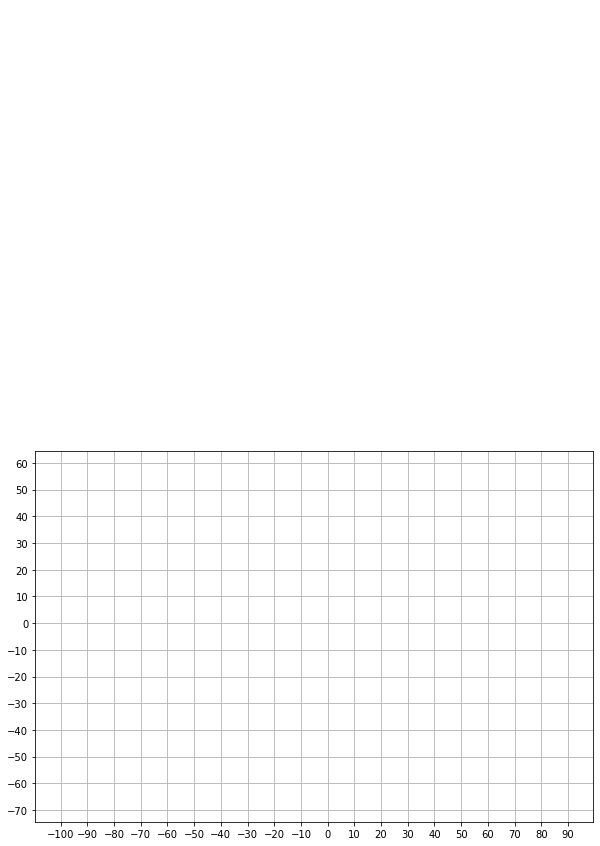

Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00


/datasets/home/home-02/70/670/y2di/cse252c_hw1/pyviso/runMatch.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1)))
/datasets/home/home-02/70/670/y2di/cse252c_hw1/pyviso/runMatch.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Translation: %.5f'%(errorTransSum / (k-1)))


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame000.jpg


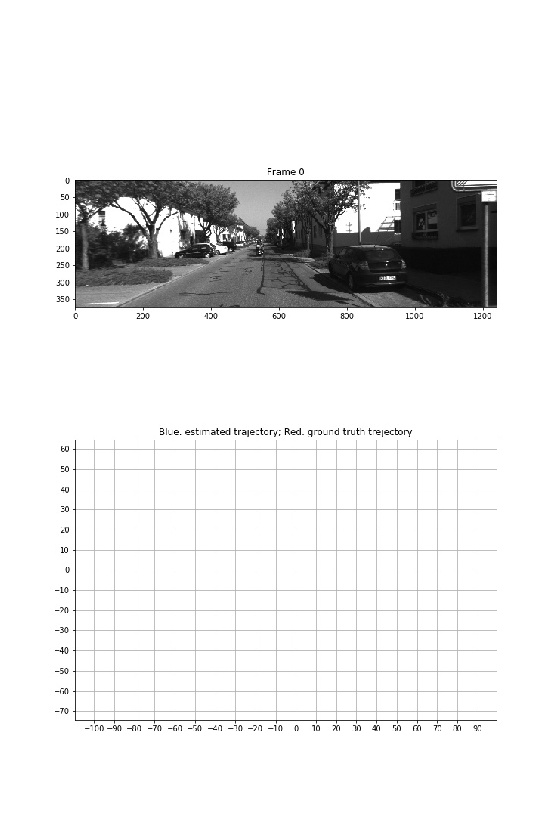

(1463, 4)
[[ 1.     -0.0027 -0.0036  0.0002]
 [ 0.0027  1.     -0.0018 -0.007 ]
 [ 0.0036  0.0018  1.      0.4836]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07455
Mean Error Translation: 97.56619
== [Result] Frame: 1, Matches 1463, Inliers: 99.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame001.jpg
(1463, 4)
[[ 1.     -0.0001 -0.0071 -0.0116]
 [ 0.      1.     -0.003  -0.0121]
 [ 0.0071  0.003   1.      0.9611]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03908
Mean Error Translation: 48.97429
== [Result] Frame: 2, Matches 1463, Inliers: 99.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame002.jpg
(1463, 4)
[[ 0.9999 -0.0008 -0.0112 -0.0185]
 [ 0.0008  1.     -0.0038 -0.0191]
 [ 0.0112  0.0038  0.9999  1.4311]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02719
Mean Error Translation: 32.77996
== [Result] Frame: 3, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame003.jpg
(1463, 4)
[[ 0.9999 -0.0014 -0.0169 -0.0217]
 [ 0.0013  1.     -0.0042 -0.0243]
 [ 0.0169  0.0042  0.9998  1.9056]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02177
Mean Error Translation: 24.68156
== [Result] Frame: 4, Matches 1463, Inliers: 98.36


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame004.jpg
(1463, 4)
[[ 0.9997 -0.0038 -0.0224 -0.0254]
 [ 0.0038  1.     -0.0041 -0.0325]
 [ 0.0224  0.004   0.9997  2.3902]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01875
Mean Error Translation: 19.82068
== [Result] Frame: 5, Matches 1463, Inliers: 97.61


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame005.jpg
(1463, 4)
[[ 0.9996 -0.0033 -0.0286 -0.0305]
 [ 0.0032  1.     -0.0047 -0.0428]
 [ 0.0286  0.0046  0.9996  2.8824]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01660
Mean Error Translation: 16.57861
== [Result] Frame: 6, Matches 1463, Inliers: 94.05


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame006.jpg
(1463, 4)
[[ 0.9995 -0.0006 -0.0328 -0.0572]
 [ 0.0004  1.     -0.0048 -0.0506]
 [ 0.0328  0.0048  0.9995  3.3795]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01489
Mean Error Translation: 14.26206
== [Result] Frame: 7, Matches 1463, Inliers: 93.85


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame007.jpg
(1463, 4)
[[ 0.9993 -0.0005 -0.0372 -0.0776]
 [ 0.0004  1.     -0.0025 -0.0599]
 [ 0.0372  0.0025  0.9993  3.8918]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01378
Mean Error Translation: 12.52268
== [Result] Frame: 8, Matches 1463, Inliers: 92.14


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame008.jpg
(1463, 4)
[[ 0.9991 -0.0019 -0.0421 -0.0987]
 [ 0.002   1.      0.001  -0.0712]
 [ 0.0421 -0.0011  0.9991  4.4211]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01318
Mean Error Translation: 11.16801
== [Result] Frame: 9, Matches 1463, Inliers: 91.80


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame009.jpg
(1463, 4)
[[ 0.999   0.0012 -0.0439 -0.1442]
 [-0.0011  1.      0.0037 -0.0741]
 [ 0.0439 -0.0036  0.999   4.9847]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01250
Mean Error Translation: 10.08084
== [Result] Frame: 10, Matches 1463, Inliers: 95.69


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame010.jpg
(1463, 4)
[[ 0.9989  0.003  -0.0465 -0.1765]
 [-0.0028  1.      0.0034 -0.0792]
 [ 0.0465 -0.0033  0.9989  5.5701]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01158
Mean Error Translation: 9.18925
== [Result] Frame: 11, Matches 1463, Inliers: 95.63


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame011.jpg
(1463, 4)
[[ 0.9988  0.0012 -0.0488 -0.2054]
 [-0.0011  1.      0.0029 -0.0782]
 [ 0.0488 -0.0029  0.9988  6.1478]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01089
Mean Error Translation: 8.44708
== [Result] Frame: 12, Matches 1463, Inliers: 90.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame012.jpg
(1463, 4)
[[ 0.9988  0.0013 -0.049  -0.2509]
 [-0.0012  1.      0.0024 -0.0807]
 [ 0.049  -0.0023  0.9988  6.7269]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01027
Mean Error Translation: 7.81889
== [Result] Frame: 13, Matches 1463, Inliers: 91.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame013.jpg
(1463, 4)
[[ 0.9987  0.0015 -0.0506 -0.285 ]
 [-0.0013  1.      0.0035 -0.0851]
 [ 0.0506 -0.0034  0.9987  7.317 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00979
Mean Error Translation: 7.27963
== [Result] Frame: 14, Matches 1463, Inliers: 94.53


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame014.jpg
(1463, 4)
[[ 0.9986 -0.0026 -0.0533 -0.3057]
 [ 0.0027  1.      0.0024 -0.0801]
 [ 0.0533 -0.0025  0.9986  7.9297]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00941
Mean Error Translation: 6.81064
== [Result] Frame: 15, Matches 1463, Inliers: 95.97


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame015.jpg
(1463, 4)
[[ 0.9985  0.0013 -0.054  -0.3554]
 [-0.0014  1.     -0.0002 -0.0807]
 [ 0.054   0.0003  0.9985  8.5364]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00902
Mean Error Translation: 6.40103
== [Result] Frame: 16, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame016.jpg
(1463, 4)
[[ 0.9985  0.0031 -0.0539 -0.4071]
 [-0.0032  1.     -0.0032 -0.0816]
 [ 0.0539  0.0034  0.9985  9.1569]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00866
Mean Error Translation: 6.03920
== [Result] Frame: 17, Matches 1463, Inliers: 99.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame017.jpg
(1463, 4)
[[ 0.9985  0.0112 -0.0535 -0.4715]
 [-0.0115  0.9999 -0.0052 -0.0859]
 [ 0.0534  0.0058  0.9986  9.7877]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00859
Mean Error Translation: 5.71759
== [Result] Frame: 18, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame018.jpg
(1463, 4)
[[ 0.9985  0.0141 -0.0538 -0.5211]
 [-0.0143  0.9999 -0.0045 -0.0979]
 [ 0.0537  0.0053  0.9985 10.436 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00828
Mean Error Translation: 5.42942
== [Result] Frame: 19, Matches 1463, Inliers: 90.57


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame019.jpg
(1463, 4)
[[ 0.9984  0.013  -0.0549 -0.5644]
 [-0.0132  0.9999 -0.0028 -0.1088]
 [ 0.0548  0.0035  0.9985 11.1083]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00794
Mean Error Translation: 5.16937
== [Result] Frame: 20, Matches 1463, Inliers: 92.69


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame020.jpg
(1463, 4)
[[ 0.9983  0.0136 -0.056  -0.6086]
 [-0.0137  0.9999 -0.0009 -0.12  ]
 [ 0.056   0.0017  0.9984 11.7755]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00760
Mean Error Translation: 4.93454
== [Result] Frame: 21, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame021.jpg
(1463, 4)
[[ 0.9983  0.0117 -0.0573 -0.6442]
 [-0.0117  0.9999 -0.0006 -0.1299]
 [ 0.0573  0.0012  0.9984 12.4216]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00735
Mean Error Translation: 4.72234
== [Result] Frame: 22, Matches 1463, Inliers: 95.42


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame022.jpg
(1463, 4)
[[ 0.9982  0.0126 -0.0585 -0.687 ]
 [-0.0127  0.9999 -0.0013 -0.1363]
 [ 0.0585  0.002   0.9983 13.065 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00709
Mean Error Translation: 4.52880
== [Result] Frame: 23, Matches 1463, Inliers: 93.30


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame023.jpg
(1463, 4)
[[ 0.9982  0.0107 -0.0596 -0.7274]
 [-0.0108  0.9999 -0.0019 -0.1452]
 [ 0.0595  0.0025  0.9982 13.7152]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00684
Mean Error Translation: 4.35124
== [Result] Frame: 24, Matches 1463, Inliers: 93.44


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame024.jpg
(1463, 4)
[[ 0.9981  0.0112 -0.06   -0.7692]
 [-0.0112  0.9999  0.0001 -0.1539]
 [ 0.06    0.0006  0.9982 14.3515]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00661
Mean Error Translation: 4.18885
== [Result] Frame: 25, Matches 1463, Inliers: 96.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame025.jpg
(1463, 4)
[[ 0.9982  0.0148 -0.058  -0.831 ]
 [-0.0146  0.9999  0.0033 -0.1577]
 [ 0.058  -0.0024  0.9983 14.9973]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00651
Mean Error Translation: 4.03887
== [Result] Frame: 26, Matches 1463, Inliers: 97.47


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame026.jpg
(1463, 4)
[[ 0.9983  0.0188 -0.0553 -0.8921]
 [-0.0184  0.9998  0.0074 -0.1668]
 [ 0.0554 -0.0063  0.9984 15.6506]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00647
Mean Error Translation: 3.89977
== [Result] Frame: 27, Matches 1463, Inliers: 95.49


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame027.jpg
(1463, 4)
[[ 0.9984  0.0206 -0.0522 -0.946 ]
 [-0.0201  0.9998  0.0097 -0.1638]
 [ 0.0524 -0.0086  0.9986 16.32  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00639
Mean Error Translation: 3.77030
== [Result] Frame: 28, Matches 1463, Inliers: 94.60


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame028.jpg
(1463, 4)
[[ 0.9985  0.0203 -0.0504 -0.9852]
 [-0.0198  0.9998  0.01   -0.162 ]
 [ 0.0506 -0.009   0.9987 17.0058]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00621
Mean Error Translation: 3.64929
== [Result] Frame: 29, Matches 1463, Inliers: 96.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame029.jpg
(1463, 4)
[[ 0.9986  0.0206 -0.0491 -1.0216]
 [-0.0202  0.9998  0.0072 -0.1653]
 [ 0.0492 -0.0062  0.9988 17.6944]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00602
Mean Error Translation: 3.53632
== [Result] Frame: 30, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame030.jpg
(1463, 4)
[[ 0.9986  0.0241 -0.0475 -1.0666]
 [-0.024   0.9997  0.0027 -0.1713]
 [ 0.0476 -0.0016  0.9989 18.3858]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00595
Mean Error Translation: 3.43067
== [Result] Frame: 31, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame031.jpg
(1463, 4)
[[ 0.9987  0.0238 -0.0462 -1.1034]
 [-0.0238  0.9997 -0.0002 -0.1755]
 [ 0.0462  0.0013  0.9989 19.0977]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00580
Mean Error Translation: 3.33121
== [Result] Frame: 32, Matches 1463, Inliers: 96.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame032.jpg
(1463, 4)
[[ 0.9987  0.0219 -0.0451 -1.141 ]
 [-0.0219  0.9998  0.0015 -0.188 ]
 [ 0.0451 -0.0005  0.999  19.8133]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00566
Mean Error Translation: 3.23794
== [Result] Frame: 33, Matches 1463, Inliers: 96.72


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame033.jpg
(1463, 4)
[[ 0.9988  0.0222 -0.044  -1.1901]
 [-0.0219  0.9997  0.0076 -0.2042]
 [ 0.0442 -0.0066  0.999  20.5305]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00560
Mean Error Translation: 3.15032
== [Result] Frame: 34, Matches 1463, Inliers: 92.48


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame034.jpg
(1463, 4)
[[ 0.9988  0.0188 -0.0456 -1.2101]
 [-0.0183  0.9998  0.0121 -0.2164]
 [ 0.0458 -0.0112  0.9989 21.2553]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00547
Mean Error Translation: 3.06763
== [Result] Frame: 35, Matches 1463, Inliers: 90.64


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame035.jpg
(1463, 4)
[[ 0.9988  0.0141 -0.0459 -1.2467]
 [-0.0136  0.9998  0.0121 -0.223 ]
 [ 0.046  -0.0114  0.9989 21.9836]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00545
Mean Error Translation: 2.98942
== [Result] Frame: 36, Matches 1463, Inliers: 85.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame036.jpg
(1463, 4)
[[ 0.9988  0.0158 -0.0453 -1.2972]
 [-0.0154  0.9998  0.0084 -0.2235]
 [ 0.0455 -0.0077  0.9989 22.6795]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00550
Mean Error Translation: 2.91630
== [Result] Frame: 37, Matches 1463, Inliers: 91.39


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame037.jpg
(1463, 4)
[[ 0.9988  0.0169 -0.0469 -1.3323]
 [-0.0167  0.9998  0.0045 -0.224 ]
 [ 0.047  -0.0037  0.9989 23.3875]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00538
Mean Error Translation: 2.84687
== [Result] Frame: 38, Matches 1463, Inliers: 93.57


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame038.jpg
(1463, 4)
[[ 0.9986  0.0175 -0.049  -1.4091]
 [-0.0173  0.9998  0.004  -0.2273]
 [ 0.049  -0.0031  0.9988 24.8124]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00526
Mean Error Translation: 2.78455
== [Result] Frame: 39, Matches 1463, Inliers: 91.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame039.jpg
(1463, 4)
[[ 0.9986  0.0136 -0.051  -1.4797]
 [-0.0134  0.9999  0.0048 -0.223 ]
 [ 0.0511 -0.0042  0.9987 26.743 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00528
Mean Error Translation: 2.73686
== [Result] Frame: 40, Matches 1463, Inliers: 90.50


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame040.jpg
(1463, 4)
[[ 0.9985  0.0152 -0.0522 -1.6046]
 [-0.0148  0.9999  0.0076 -0.2388]
 [ 0.0523 -0.0068  0.9986 28.9205]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00521
Mean Error Translation: 2.69788
== [Result] Frame: 41, Matches 1463, Inliers: 87.97


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame041.jpg
(1463, 4)
[[ 0.9985  0.0158 -0.0527 -1.6509]
 [-0.0154  0.9998  0.0079 -0.2345]
 [ 0.0528 -0.0071  0.9986 29.5563]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00512
Mean Error Translation: 2.64345
== [Result] Frame: 42, Matches 1463, Inliers: 86.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame042.jpg
(1463, 4)
[[ 0.9984  0.0164 -0.0534 -1.6902]
 [-0.0159  0.9998  0.0096 -0.2327]
 [ 0.0536 -0.0088  0.9985 30.2109]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00503
Mean Error Translation: 2.59084
== [Result] Frame: 43, Matches 1463, Inliers: 80.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame043.jpg
(1463, 4)
[[ 0.9984  0.0146 -0.0545 -1.7159]
 [-0.014   0.9998  0.0129 -0.237 ]
 [ 0.0546 -0.0121  0.9984 30.8579]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00497
Mean Error Translation: 2.54087
== [Result] Frame: 44, Matches 1463, Inliers: 84.89


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame044.jpg
(1463, 4)
[[ 0.9983  0.0215 -0.0548 -1.7649]
 [-0.0207  0.9997  0.0152 -0.2376]
 [ 0.0551 -0.0141  0.9984 31.5274]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00489
Mean Error Translation: 2.49230
== [Result] Frame: 45, Matches 1463, Inliers: 89.13


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame045.jpg
(1463, 4)
[[ 0.9983  0.0208 -0.0548 -1.8124]
 [-0.0201  0.9997  0.0135 -0.2257]
 [ 0.0551 -0.0124  0.9984 32.2355]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00486
Mean Error Translation: 2.44503
== [Result] Frame: 46, Matches 1463, Inliers: 93.98


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame046.jpg
(1463, 4)
[[ 0.9983  0.0208 -0.0549 -1.8568]
 [-0.0203  0.9997  0.0114 -0.2212]
 [ 0.0551 -0.0103  0.9984 32.9556]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00477
Mean Error Translation: 2.39923
== [Result] Frame: 47, Matches 1463, Inliers: 94.87


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame047.jpg
(1463, 4)
[[ 0.9982  0.0291 -0.0531 -1.9279]
 [-0.0287  0.9995  0.0093 -0.2265]
 [ 0.0533 -0.0078  0.9985 33.6726]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00485
Mean Error Translation: 2.35528
== [Result] Frame: 48, Matches 1463, Inliers: 92.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame048.jpg
(1463, 4)
[[ 0.9981  0.0336 -0.0522 -1.9937]
 [-0.0332  0.9994  0.0095 -0.2322]
 [ 0.0525 -0.0077  0.9986 34.3999]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00490
Mean Error Translation: 2.31283
== [Result] Frame: 49, Matches 1463, Inliers: 88.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame049.jpg
(1463, 4)
[[ 0.9981  0.0324 -0.0533 -2.0388]
 [-0.0319  0.9994  0.0109 -0.2361]
 [ 0.0536 -0.0091  0.9985 35.1552]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00483
Mean Error Translation: 2.27150
== [Result] Frame: 50, Matches 1463, Inliers: 87.08


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame050.jpg


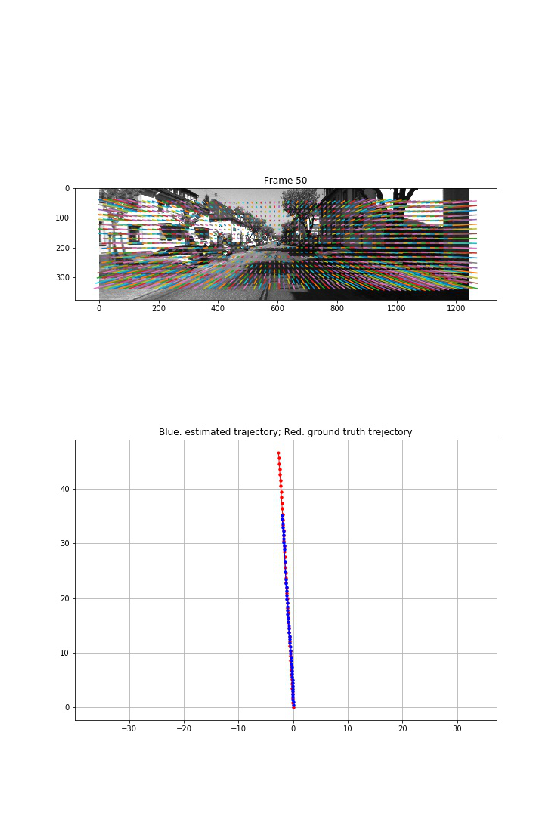

(1463, 4)
[[ 0.9979  0.0367 -0.0527 -2.1043]
 [-0.0361  0.9993  0.0126 -0.2482]
 [ 0.0531 -0.0107  0.9985 35.934 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00485
Mean Error Translation: 2.23122
== [Result] Frame: 51, Matches 1463, Inliers: 87.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame051.jpg
(1463, 4)
[[ 0.9978  0.0404 -0.052  -2.1657]
 [-0.04    0.9992  0.0092 -0.2534]
 [ 0.0523 -0.0071  0.9986 36.7306]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00481
Mean Error Translation: 2.19200
== [Result] Frame: 52, Matches 1463, Inliers: 87.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame052.jpg
(1463, 4)
[[ 0.9977  0.0403 -0.0537 -2.2125]
 [-0.04    0.9992  0.0059 -0.2677]
 [ 0.0539 -0.0037  0.9985 37.6222]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00478
Mean Error Translation: 2.15236
== [Result] Frame: 53, Matches 1463, Inliers: 90.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame053.jpg
(1463, 4)
[[ 0.9977  0.0408 -0.0545 -2.2695]
 [-0.0406  0.9992  0.0046 -0.2722]
 [ 0.0547 -0.0024  0.9985 38.5777]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00471
Mean Error Translation: 2.11322
== [Result] Frame: 54, Matches 1463, Inliers: 95.35


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame054.jpg
(1463, 4)
[[ 0.9977  0.0383 -0.0552 -2.3172]
 [-0.0379  0.9992  0.0082 -0.2792]
 [ 0.0555 -0.0061  0.9984 39.5677]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00468
Mean Error Translation: 2.07546
== [Result] Frame: 55, Matches 1463, Inliers: 97.20


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame055.jpg
(1463, 4)
[[ 0.9977  0.0387 -0.0551 -2.3869]
 [-0.0381  0.9992  0.012  -0.2963]
 [ 0.0556 -0.0099  0.9984 40.66  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00468
Mean Error Translation: 2.04048
== [Result] Frame: 56, Matches 1463, Inliers: 93.85


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame056.jpg
(1463, 4)
[[ 0.9978  0.0354 -0.0565 -2.4323]
 [-0.0347  0.9993  0.0128 -0.3035]
 [ 0.057  -0.0108  0.9983 41.8138]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00465
Mean Error Translation: 2.00795
== [Result] Frame: 57, Matches 1463, Inliers: 96.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame057.jpg
(1463, 4)
[[ 0.9978  0.0329 -0.0574 -2.4677]
 [-0.0322  0.9994  0.0121 -0.3087]
 [ 0.0578 -0.0102  0.9983 42.4965]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00459
Mean Error Translation: 1.97820
== [Result] Frame: 58, Matches 1463, Inliers: 98.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame058.jpg
(1463, 4)
[[ 0.9978  0.0309 -0.0584 -2.5033]
 [-0.0303  0.9995  0.0112 -0.3133]
 [ 0.0587 -0.0094  0.9982 43.1616]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00456
Mean Error Translation: 1.94977
== [Result] Frame: 59, Matches 1463, Inliers: 96.17


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame059.jpg
(1463, 4)
[[ 0.9977  0.0304 -0.0598 -2.5417]
 [-0.0297  0.9995  0.0126 -0.3154]
 [ 0.0601 -0.0108  0.9981 43.8303]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00451
Mean Error Translation: 1.92214
== [Result] Frame: 60, Matches 1463, Inliers: 94.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame060.jpg
(1463, 4)
[[ 0.9978  0.0292 -0.0599 -2.5913]
 [-0.0282  0.9995  0.0166 -0.3134]
 [ 0.0604 -0.0149  0.9981 44.5113]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00448
Mean Error Translation: 1.89526
== [Result] Frame: 61, Matches 1463, Inliers: 93.57


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame061.jpg
(1463, 4)
[[ 0.9977  0.0339 -0.058  -2.6598]
 [-0.0327  0.9992  0.0215 -0.3115]
 [ 0.0587 -0.0196  0.9981 45.2124]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00456
Mean Error Translation: 1.86890
== [Result] Frame: 62, Matches 1463, Inliers: 94.60


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame062.jpg
(1463, 4)
[[ 0.9976  0.0378 -0.0586 -2.7098]
 [-0.0364  0.999   0.0242 -0.3118]
 [ 0.0595 -0.022   0.998  45.949 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00454
Mean Error Translation: 1.84268
== [Result] Frame: 63, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame063.jpg
(1463, 4)
[[ 0.9974  0.0406 -0.0598 -2.763 ]
 [-0.0395  0.999   0.0207 -0.3122]
 [ 0.0605 -0.0183  0.998  46.6535]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00451
Mean Error Translation: 1.81760
== [Result] Frame: 64, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame064.jpg
(1463, 4)
[[ 0.9972  0.0403 -0.0633 -2.7926]
 [-0.0395  0.9991  0.0141 -0.32  ]
 [ 0.0638 -0.0116  0.9979 47.317 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00450
Mean Error Translation: 1.79370
== [Result] Frame: 65, Matches 1463, Inliers: 96.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame065.jpg
(1463, 4)
[[ 0.997   0.0453 -0.0632 -2.853 ]
 [-0.0447  0.999   0.0096 -0.3199]
 [ 0.0636 -0.0068  0.998  47.9855]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00453
Mean Error Translation: 1.77028
== [Result] Frame: 66, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame066.jpg
(1463, 4)
[[ 0.9966  0.0532 -0.0633 -2.9146]
 [-0.0526  0.9986  0.0105 -0.3192]
 [ 0.0638 -0.0072  0.9979 48.6619]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00453
Mean Error Translation: 1.74739
== [Result] Frame: 67, Matches 1463, Inliers: 95.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame067.jpg
(1463, 4)
[[ 0.9963  0.0575 -0.0639 -2.968 ]
 [-0.0568  0.9983  0.0129 -0.3216]
 [ 0.0645 -0.0093  0.9979 49.3463]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00449
Mean Error Translation: 1.72488
== [Result] Frame: 68, Matches 1463, Inliers: 93.64


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame068.jpg
(1463, 4)
[[ 0.9961  0.0591 -0.0658 -3.0084]
 [-0.0583  0.9982  0.0143 -0.3221]
 [ 0.0665 -0.0104  0.9977 50.0029]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00445
Mean Error Translation: 1.70322
== [Result] Frame: 69, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame069.jpg
(1463, 4)
[[ 0.996   0.061  -0.0658 -3.0662]
 [-0.0602  0.9981  0.0143 -0.3229]
 [ 0.0666 -0.0102  0.9977 50.6287]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.68238
== [Result] Frame: 70, Matches 1463, Inliers: 93.85


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame070.jpg
(1463, 4)
[[ 0.9957  0.0653 -0.0659 -3.1309]
 [-0.0644  0.9978  0.0154 -0.3253]
 [ 0.0668 -0.011   0.9977 51.2564]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.66190
== [Result] Frame: 71, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame071.jpg
(1463, 4)
[[ 0.9957  0.0643 -0.0671 -3.1778]
 [-0.0634  0.9979  0.0155 -0.3202]
 [ 0.0679 -0.0112  0.9976 51.9102]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00442
Mean Error Translation: 1.64151
== [Result] Frame: 72, Matches 1463, Inliers: 90.91


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame072.jpg
(1463, 4)
[[ 0.9957  0.0625 -0.0683 -3.2202]
 [-0.0616  0.998   0.0159 -0.321 ]
 [ 0.0692 -0.0116  0.9975 52.5572]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00439
Mean Error Translation: 1.62156
== [Result] Frame: 73, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame073.jpg
(1463, 4)
[[ 0.9956  0.062  -0.0698 -3.2743]
 [-0.0609  0.998   0.0174 -0.3252]
 [ 0.0708 -0.0131  0.9974 53.383 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00435
Mean Error Translation: 1.59998
== [Result] Frame: 74, Matches 1463, Inliers: 91.80


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame074.jpg
(1463, 4)
[[ 0.9952  0.0688 -0.0698 -3.3428]
 [-0.0675  0.9975  0.021  -0.3342]
 [ 0.071  -0.0162  0.9973 54.0386]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00438
Mean Error Translation: 1.58065
== [Result] Frame: 75, Matches 1463, Inliers: 95.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame075.jpg
(1463, 4)
[[ 0.9951  0.0682 -0.072  -3.378 ]
 [-0.0665  0.9974  0.026  -0.3413]
 [ 0.0736 -0.0211  0.9971 54.6855]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00437
Mean Error Translation: 1.56184
== [Result] Frame: 76, Matches 1463, Inliers: 94.33


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame076.jpg
(1463, 4)
[[ 0.9948  0.0709 -0.0736 -3.431 ]
 [-0.069   0.9972  0.0281 -0.3399]
 [ 0.0753 -0.0228  0.9969 55.3733]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00432
Mean Error Translation: 1.54277
== [Result] Frame: 77, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame077.jpg
(1463, 4)
[[ 0.9945  0.0717 -0.0761 -3.4748]
 [-0.07    0.9973  0.0241 -0.3367]
 [ 0.0776 -0.0187  0.9968 56.0415]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00431
Mean Error Translation: 1.52419
== [Result] Frame: 78, Matches 1463, Inliers: 98.02


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame078.jpg
(1463, 4)
[[ 0.9944  0.0693 -0.0792 -3.5128]
 [-0.0682  0.9975  0.017  -0.3342]
 [ 0.0802 -0.0115  0.9967 56.6987]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00432
Mean Error Translation: 1.50596
== [Result] Frame: 79, Matches 1463, Inliers: 94.53


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame079.jpg
(1463, 4)
[[ 0.9944  0.0666 -0.0822 -3.5496]
 [-0.0659  0.9978  0.011  -0.3289]
 [ 0.0827 -0.0056  0.9966 57.2921]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00429
Mean Error Translation: 1.48870
== [Result] Frame: 80, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame080.jpg
(1463, 4)
[[ 0.9942  0.0674 -0.0832 -3.5927]
 [-0.0668  0.9977  0.01   -0.3266]
 [ 0.0837 -0.0044  0.9965 57.813 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00426
Mean Error Translation: 1.47252
== [Result] Frame: 81, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame081.jpg
(1463, 4)
[[ 0.994   0.0712 -0.0833 -3.6443]
 [-0.0704  0.9974  0.0135 -0.3259]
 [ 0.0841 -0.0075  0.9964 58.294 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00424
Mean Error Translation: 1.45697
== [Result] Frame: 82, Matches 1463, Inliers: 96.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame082.jpg
(1463, 4)
[[ 0.9939  0.0717 -0.0843 -3.6886]
 [-0.0706  0.9974  0.0154 -0.3245]
 [ 0.0851 -0.0094  0.9963 58.7576]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00421
Mean Error Translation: 1.44179
== [Result] Frame: 83, Matches 1463, Inliers: 97.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame083.jpg
(1463, 4)
[[ 0.9939  0.0715 -0.0839 -3.7417]
 [-0.0708  0.9974  0.0115 -0.32  ]
 [ 0.0845 -0.0055  0.9964 59.1944]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00423
Mean Error Translation: 1.42697
== [Result] Frame: 84, Matches 1463, Inliers: 96.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame084.jpg
(1463, 4)
[[ 0.9943  0.0659 -0.0836 -3.7773]
 [-0.0656  0.9978  0.0062 -0.321 ]
 [ 0.0838 -0.0006  0.9965 59.6014]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00422
Mean Error Translation: 1.41262
== [Result] Frame: 85, Matches 1463, Inliers: 97.81


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame085.jpg
(1463, 4)
[[ 0.9946  0.0628 -0.0831 -3.7998]
 [-0.0629  0.998   0.0017 -0.3271]
 [ 0.0831  0.0036  0.9965 59.9749]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00420
Mean Error Translation: 1.39879
== [Result] Frame: 86, Matches 1463, Inliers: 98.36


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame086.jpg
(1463, 4)
[[ 0.9946  0.0635 -0.0815 -3.8109]
 [-0.0636  0.998   0.0014 -0.3314]
 [ 0.0815  0.0038  0.9967 60.333 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00418
Mean Error Translation: 1.38534
== [Result] Frame: 87, Matches 1463, Inliers: 99.73


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame087.jpg
(1463, 4)
[[ 0.9946  0.0696 -0.077  -3.8465]
 [-0.0695  0.9976  0.0042 -0.3355]
 [ 0.0771  0.0011  0.997  60.6849]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00414
Mean Error Translation: 1.37209
== [Result] Frame: 88, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame088.jpg
(1463, 4)
[[ 0.995   0.0684 -0.0732 -3.8596]
 [-0.0681  0.9977  0.0077 -0.3459]
 [ 0.0736 -0.0027  0.9973 61.0318]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00411
Mean Error Translation: 1.35904
== [Result] Frame: 89, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame089.jpg
(1463, 4)
[[ 0.9955  0.0669 -0.0671 -3.8795]
 [-0.0663  0.9977  0.012  -0.3532]
 [ 0.0677 -0.0075  0.9977 61.3781]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00412
Mean Error Translation: 1.34614
== [Result] Frame: 90, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame090.jpg
(1463, 4)
[[ 0.9962  0.0634 -0.059  -3.8915]
 [-0.0626  0.9979  0.0153 -0.3615]
 [ 0.0598 -0.0115  0.9981 61.7282]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00409
Mean Error Translation: 1.33334
== [Result] Frame: 91, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame091.jpg
(1463, 4)
[[ 0.9965  0.0674 -0.0486 -3.9051]
 [-0.0668  0.9977  0.0148 -0.3657]
 [ 0.0494 -0.0115  0.9987 62.0785]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 1.32062
== [Result] Frame: 92, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame092.jpg
(1463, 4)
[[ 0.9967  0.0731 -0.0341 -3.9113]
 [-0.0727  0.9973  0.0139 -0.3725]
 [ 0.035  -0.0113  0.9993 62.4186]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00403
Mean Error Translation: 1.30817
== [Result] Frame: 93, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame093.jpg
(1463, 4)
[[ 0.9968  0.0779 -0.0167 -3.9068]
 [-0.0777  0.9969  0.0138 -0.3794]
 [ 0.0177 -0.0125  0.9998 62.7526]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00400
Mean Error Translation: 1.29590
== [Result] Frame: 94, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame094.jpg
(1463, 4)
[[ 0.9971  0.0765  0.0041 -3.8823]
 [-0.0765  0.997   0.0139 -0.391 ]
 [-0.003  -0.0141  0.9999 63.0776]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00398
Mean Error Translation: 1.28384
== [Result] Frame: 95, Matches 1463, Inliers: 99.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame095.jpg
(1463, 4)
[[ 0.9968  0.0741  0.0295 -3.8512]
 [-0.0745  0.9971  0.0136 -0.398 ]
 [-0.0284 -0.0157  0.9995 63.4022]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 1.27187
== [Result] Frame: 96, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame096.jpg
(1463, 4)
[[ 0.9957  0.0723  0.0574 -3.8025]
 [-0.0731  0.9972  0.0135 -0.4057]
 [-0.0563 -0.0177  0.9983 63.7234]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00393
Mean Error Translation: 1.26012
== [Result] Frame: 97, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame097.jpg
(1463, 4)
[[ 0.9939  0.0676  0.0866 -3.7204]
 [-0.0689  0.9975  0.0125 -0.4124]
 [-0.0855 -0.0183  0.9962 64.0396]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 1.24861
== [Result] Frame: 98, Matches 1463, Inliers: 99.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame098.jpg
(1463, 4)
[[ 0.9903  0.0665  0.122  -3.6453]
 [-0.0683  0.9976  0.0107 -0.417 ]
 [-0.121  -0.0189  0.9925 64.3582]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00395
Mean Error Translation: 1.23714
== [Result] Frame: 99, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame099.jpg
(1463, 4)
[[ 0.9851  0.0629  0.1601 -3.5414]
 [-0.0649  0.9979  0.0078 -0.4237]
 [-0.1592 -0.0181  0.9871 64.6651]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 1.22599
== [Result] Frame: 100, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame100.jpg


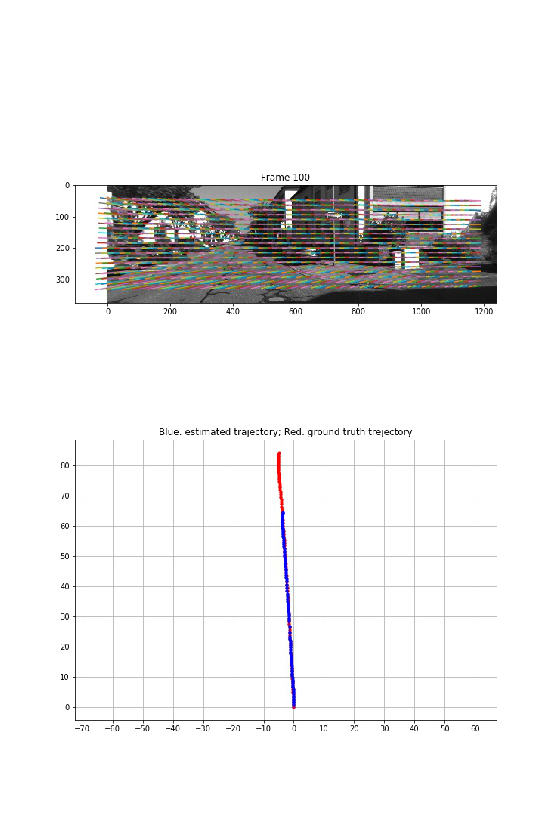

(1463, 4)
[[ 0.9781  0.0564  0.2004 -3.4095]
 [-0.0584  0.9983  0.0042 -0.4307]
 [-0.1998 -0.0158  0.9797 64.964 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 1.21501
== [Result] Frame: 101, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame101.jpg
(1463, 4)
[[ 0.9678  0.0537  0.2458 -3.2758]
 [-0.0552  0.9985 -0.0008 -0.442 ]
 [-0.2454 -0.0128  0.9693 65.2551]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 1.20407
== [Result] Frame: 102, Matches 1463, Inliers: 97.61


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame102.jpg
(1463, 4)
[[ 0.9537  0.0521  0.2962 -3.1362]
 [-0.0525  0.9986 -0.0064 -0.4529]
 [-0.2961 -0.0095  0.9551 65.5364]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 1.19340
== [Result] Frame: 103, Matches 1463, Inliers: 96.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame103.jpg
(1463, 4)
[[ 0.9349  0.0512  0.3513 -2.9949]
 [-0.0504  0.9987 -0.0113 -0.4581]
 [-0.3514 -0.0072  0.9362 65.8135]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 1.18275
== [Result] Frame: 104, Matches 1463, Inliers: 97.61


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame104.jpg
(1463, 4)
[[ 0.9118  0.0506  0.4076 -2.8356]
 [-0.0484  0.9987 -0.0157 -0.4659]
 [-0.4078 -0.0054  0.913  66.0766]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00403
Mean Error Translation: 1.17240
== [Result] Frame: 105, Matches 1463, Inliers: 97.47


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame105.jpg
(1463, 4)
[[ 0.8841  0.0489  0.4648 -2.6572]
 [-0.0447  0.9988 -0.0201 -0.4755]
 [-0.4652 -0.003   0.8852 66.3274]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 1.16218
== [Result] Frame: 106, Matches 1463, Inliers: 97.74


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame106.jpg
(1463, 4)
[[ 0.8539  0.0432  0.5186 -2.4421]
 [-0.0353  0.9991 -0.025  -0.4905]
 [-0.5192  0.0031  0.8547 66.539 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 1.15208
== [Result] Frame: 107, Matches 1463, Inliers: 98.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame107.jpg
(1463, 4)
[[ 0.82    0.0397  0.571  -2.2215]
 [-0.0285  0.9992 -0.0284 -0.506 ]
 [-0.5717  0.007   0.8204 66.7456]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 1.14222
== [Result] Frame: 108, Matches 1463, Inliers: 98.91


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame108.jpg
(1463, 4)
[[ 0.7897  0.0351  0.6125 -1.1401]
 [-0.0136  0.9991 -0.0398 -0.5344]
 [-0.6134  0.0231  0.7895 66.9867]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00431
Mean Error Translation: 1.13912
== [Result] Frame: 109, Matches 1463, Inliers: 99.52


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame109.jpg
(1463, 4)
[[ 0.7553  0.0317  0.6546 -0.8331]
 [-0.0047  0.9991 -0.0429 -0.5533]
 [-0.6554  0.0293  0.7547 67.0997]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.13000
== [Result] Frame: 110, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame110.jpg
(1463, 4)
[[ 0.7181  0.028   0.6954 -0.5196]
 [ 0.0059  0.9989 -0.0463 -0.5645]
 [-0.6959  0.0374  0.7172 67.2202]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00453
Mean Error Translation: 1.12078
== [Result] Frame: 111, Matches 1463, Inliers: 95.83


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame111.jpg
(1463, 4)
[[ 0.673   0.0269  0.7392 -0.2799]
 [ 0.0109  0.9989 -0.0463 -0.5854]
 [-0.7396  0.0392  0.6719 67.3988]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00452
Mean Error Translation: 1.11155
== [Result] Frame: 112, Matches 1463, Inliers: 98.15


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame112.jpg
(1463, 4)
[[ 0.629   0.0246  0.777  -0.0167]
 [ 0.0184  0.9987 -0.0465 -0.6011]
 [-0.7772  0.0435  0.6278 67.5488]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00450
Mean Error Translation: 1.10240
== [Result] Frame: 113, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame113.jpg
(1463, 4)
[[ 0.5855  0.0264  0.8102  0.4176]
 [ 0.02    0.9987 -0.047  -0.6259]
 [-0.8104  0.0437  0.5842 67.7638]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00447
Mean Error Translation: 1.09374
== [Result] Frame: 114, Matches 1463, Inliers: 97.33


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame114.jpg
(1463, 4)
[[ 0.5404  0.0284  0.8409  0.8824]
 [ 0.0199  0.9987 -0.0465 -0.6589]
 [-0.8412  0.0418  0.5392 67.9967]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00446
Mean Error Translation: 1.08546
== [Result] Frame: 115, Matches 1463, Inliers: 98.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame115.jpg
(1463, 4)
[[ 0.4978  0.0307  0.8667  1.3884]
 [ 0.0214  0.9986 -0.0476 -0.6852]
 [-0.867   0.0422  0.4965 68.1959]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.07752
== [Result] Frame: 116, Matches 1463, Inliers: 95.49


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame116.jpg
(1463, 4)
[[ 0.4577  0.0275  0.8887  1.8956]
 [ 0.0311  0.9984 -0.0469 -0.7117]
 [-0.8886  0.0491  0.4561 68.3712]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00442
Mean Error Translation: 1.06970
== [Result] Frame: 117, Matches 1463, Inliers: 95.83


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame117.jpg
(1463, 4)
[[ 0.4206  0.0191  0.9071  2.4585]
 [ 0.0485  0.9979 -0.0435 -0.7337]
 [-0.906   0.0623  0.4187 68.5243]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00438
Mean Error Translation: 1.06230
== [Result] Frame: 118, Matches 1463, Inliers: 96.99


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame118.jpg
(1463, 4)
[[ 0.3862  0.0155  0.9223  3.0323]
 [ 0.0538  0.9978 -0.0392 -0.7574]
 [-0.9208  0.0648  0.3845 68.6996]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00437
Mean Error Translation: 1.05519
== [Result] Frame: 119, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame119.jpg
(1463, 4)
[[ 0.3534  0.0193  0.9353  3.6114]
 [ 0.0528  0.9978 -0.0405 -0.7913]
 [-0.934   0.0636  0.3516 68.8927]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00435
Mean Error Translation: 1.04831
== [Result] Frame: 120, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame120.jpg
(1463, 4)
[[ 0.3223  0.0265  0.9463  4.289 ]
 [ 0.0448  0.9981 -0.0433 -0.8459]
 [-0.9456  0.0564  0.3205 69.1151]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00434
Mean Error Translation: 1.04236
== [Result] Frame: 121, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame121.jpg
(1463, 4)
[[ 0.2943  0.0307  0.9552  5.0097]
 [ 0.0423  0.9981 -0.0452 -0.9011]
 [-0.9548  0.0537  0.2925 69.3171]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00433
Mean Error Translation: 1.03675
== [Result] Frame: 122, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame122.jpg
(1463, 4)
[[ 0.2687  0.0327  0.9627  5.7707]
 [ 0.0433  0.998  -0.046  -0.9498]
 [-0.9623  0.054   0.2667 69.4959]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00431
Mean Error Translation: 1.03142
== [Result] Frame: 123, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame123.jpg
(1463, 4)
[[ 0.2461  0.0333  0.9687  6.5676]
 [ 0.0527  0.9975 -0.0477 -0.9934]
 [-0.9678  0.0628  0.2438 69.6308]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00430
Mean Error Translation: 1.02632
== [Result] Frame: 124, Matches 1463, Inliers: 97.95


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame124.jpg
(1463, 4)
[[ 0.2267  0.0391  0.9732  7.4608]
 [ 0.0603  0.9967 -0.0541 -1.0176]
 [-0.9721  0.0709  0.2236 69.7733]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00429
Mean Error Translation: 1.02197
== [Result] Frame: 125, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame125.jpg
(1463, 4)
[[ 0.2072  0.0455  0.9772  8.428 ]
 [ 0.0633  0.9962 -0.0598 -1.0455]
 [-0.9762  0.0742  0.2036 69.9431]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00427
Mean Error Translation: 1.01826
== [Result] Frame: 126, Matches 1463, Inliers: 92.82


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame126.jpg
(1463, 4)
[[ 0.19    0.0462  0.9807  9.4958]
 [ 0.0621  0.9963 -0.059  -1.1076]
 [-0.9798  0.0721  0.1864 70.1238]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00425
Mean Error Translation: 1.01525
== [Result] Frame: 127, Matches 1463, Inliers: 92.89


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame127.jpg
(1463, 4)
[[ 0.1743  0.0422  0.9838 10.6774]
 [ 0.0608  0.9967 -0.0535 -1.1912]
 [-0.9828  0.0691  0.1711 70.3215]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00423
Mean Error Translation: 1.01305
== [Result] Frame: 128, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame128.jpg
(1463, 4)
[[ 0.1606  0.0388  0.9863 11.8641]
 [ 0.0627  0.9968 -0.0494 -1.2689]
 [-0.985   0.0698  0.1576 70.4676]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00421
Mean Error Translation: 1.01081
== [Result] Frame: 129, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame129.jpg
(1463, 4)
[[ 0.1479  0.0361  0.9883 13.096 ]
 [ 0.0652  0.9968 -0.0462 -1.3436]
 [-0.9868  0.0713  0.1451 70.6111]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00419
Mean Error Translation: 1.00885
== [Result] Frame: 130, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame130.jpg
(1463, 4)
[[ 0.1353  0.0348  0.9902 13.435 ]
 [ 0.07    0.9965 -0.0446 -1.3625]
 [-0.9883  0.0754  0.1324 70.6576]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00417
Mean Error Translation: 1.00238
== [Result] Frame: 131, Matches 1463, Inliers: 94.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame131.jpg
(1463, 4)
[[ 0.1249  0.035   0.9916 13.7941]
 [ 0.0738  0.9963 -0.0445 -1.3808]
 [-0.9894  0.0787  0.1218 70.6977]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00414
Mean Error Translation: 0.99597
== [Result] Frame: 132, Matches 1463, Inliers: 96.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame132.jpg
(1463, 4)
[[ 0.1167  0.0353  0.9925 14.1705]
 [ 0.0765  0.9961 -0.0444 -1.3995]
 [-0.9902  0.0811  0.1135 70.74  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00411
Mean Error Translation: 0.98965
== [Result] Frame: 133, Matches 1463, Inliers: 98.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame133.jpg
(1463, 4)
[[ 0.1107  0.0353  0.9932 14.5593]
 [ 0.0787  0.9959 -0.0442 -1.4198]
 [-0.9907  0.083   0.1075 70.7828]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 0.98346
== [Result] Frame: 134, Matches 1463, Inliers: 98.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame134.jpg
(1463, 4)
[[ 0.1045  0.036   0.9939 14.957 ]
 [ 0.0807  0.9957 -0.0446 -1.4411]
 [-0.9913  0.0848  0.1011 70.8245]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 0.97742
== [Result] Frame: 135, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame135.jpg
(1463, 4)
[[ 0.0984  0.0362  0.9945 15.3656]
 [ 0.0816  0.9957 -0.0444 -1.463 ]
 [-0.9918  0.0856  0.0951 70.8612]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.97153
== [Result] Frame: 136, Matches 1463, Inliers: 97.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame136.jpg
(1463, 4)
[[ 0.0942  0.0366  0.9949 15.8043]
 [ 0.0842  0.9954 -0.0446 -1.4817]
 [-0.992   0.088   0.0907 70.8966]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 0.96565
== [Result] Frame: 137, Matches 1463, Inliers: 93.16


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame137.jpg
(1463, 4)
[[ 0.0914  0.0366  0.9951 16.5518]
 [ 0.087   0.9952 -0.0446 -1.5178]
 [-0.992   0.0907  0.0878 70.9551]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00400
Mean Error Translation: 0.95966
== [Result] Frame: 138, Matches 1463, Inliers: 91.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame138.jpg
(1463, 4)
[[ 0.0886  0.0359  0.9954 17.3368]
 [ 0.0901  0.995  -0.0439 -1.5575]
 [-0.992   0.0935  0.0849 71.0158]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00399
Mean Error Translation: 0.95388
== [Result] Frame: 139, Matches 1463, Inliers: 91.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame139.jpg
(1463, 4)
[[ 0.0861  0.0352  0.9957 18.2221]
 [ 0.0934  0.9947 -0.0432 -1.599 ]
 [-0.9919  0.0967  0.0824 71.089 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00398
Mean Error Translation: 0.94880
== [Result] Frame: 140, Matches 1463, Inliers: 91.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame140.jpg
(1463, 4)
[[ 0.0845  0.0345  0.9958 19.1475]
 [ 0.0985  0.9942 -0.0428 -1.6484]
 [-0.9915  0.1017  0.0807 71.1736]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 0.94396
== [Result] Frame: 141, Matches 1463, Inliers: 89.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame141.jpg
(1463, 4)
[[ 0.0856  0.0346  0.9957 20.2139]
 [ 0.1026  0.9938 -0.0433 -1.6878]
 [-0.991   0.1059  0.0815 71.2618]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.94007
== [Result] Frame: 142, Matches 1463, Inliers: 96.10


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame142.jpg
(1463, 4)
[[ 0.0893  0.034   0.9954 21.2561]
 [ 0.1085  0.9931 -0.0436 -1.7407]
 [-0.9901  0.1119  0.085  71.3247]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 0.93588
== [Result] Frame: 143, Matches 1463, Inliers: 93.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame143.jpg
(1463, 4)
[[ 0.0943  0.0341  0.995  21.8189]
 [ 0.1134  0.9925 -0.0448 -1.7629]
 [-0.9891  0.117   0.0897 71.3651]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 0.93051
== [Result] Frame: 144, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame144.jpg
(1463, 4)
[[ 0.1008  0.033   0.9944 22.3582]
 [ 0.1184  0.9919 -0.0449 -1.7915]
 [-0.9878  0.1223  0.0961 71.3961]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00399
Mean Error Translation: 0.92548
== [Result] Frame: 145, Matches 1463, Inliers: 92.41


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame145.jpg
(1463, 4)
[[ 0.1078  0.0301  0.9937 22.9164]
 [ 0.1274  0.9909 -0.0438 -1.823 ]
 [-0.986   0.1313  0.103  71.4213]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.92051
== [Result] Frame: 146, Matches 1463, Inliers: 96.58


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame146.jpg
(1463, 4)
[[ 0.1134  0.0279  0.9932 23.4707]
 [ 0.1308  0.9905 -0.0427 -1.852 ]
 [-0.9849  0.1347  0.1087 71.468 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00405
Mean Error Translation: 0.91573
== [Result] Frame: 147, Matches 1463, Inliers: 99.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame147.jpg
(1463, 4)
[[ 0.1187  0.0254  0.9926 24.0369]
 [ 0.13    0.9907 -0.0409 -1.883 ]
 [-0.9844  0.1339  0.1143 71.5275]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00405
Mean Error Translation: 0.91104
== [Result] Frame: 148, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame148.jpg
(1463, 4)
[[ 0.1236  0.0239  0.992  24.6294]
 [ 0.1309  0.9906 -0.0402 -1.9124]
 [-0.9837  0.1349  0.1193 71.5975]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.90629
== [Result] Frame: 149, Matches 1463, Inliers: 99.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame149.jpg
(1463, 4)
[[ 0.1281  0.0247  0.9915 25.2266]
 [ 0.1307  0.9906 -0.0416 -1.9424]
 [-0.9831  0.1349  0.1236 71.6758]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.90163
== [Result] Frame: 150, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame150.jpg


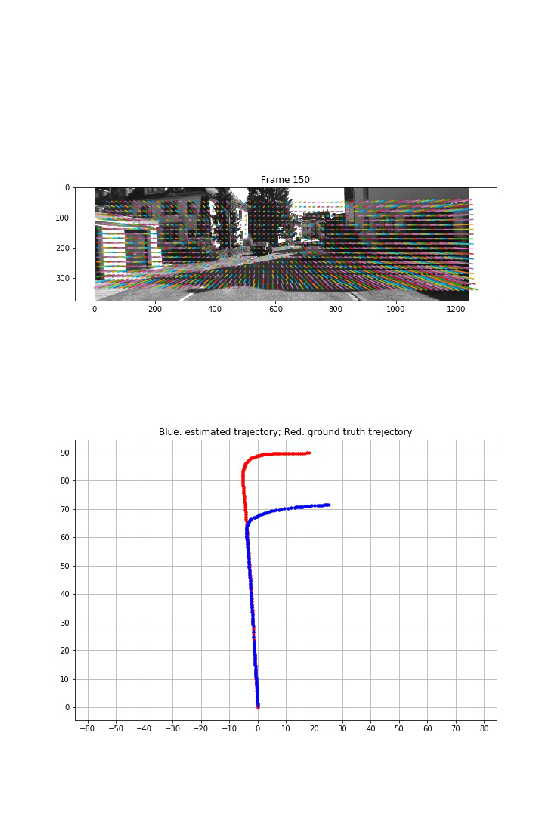

(1463, 4)
[[ 0.1306  0.0288  0.991  25.8086]
 [ 0.1295  0.9905 -0.0459 -1.9746]
 [-0.9829  0.1343  0.1257 71.7621]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00403
Mean Error Translation: 0.89715
== [Result] Frame: 151, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame151.jpg
(1463, 4)
[[ 0.1307  0.0343  0.9908 26.3711]
 [ 0.1241  0.991  -0.0507 -2.0088]
 [-0.9836  0.1296  0.1253 71.856 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00401
Mean Error Translation: 0.89288
== [Result] Frame: 152, Matches 1463, Inliers: 98.15


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame152.jpg
(1463, 4)
[[ 0.131   0.037   0.9907 26.9497]
 [ 0.1235  0.9909 -0.0533 -2.0444]
 [-0.9837  0.1294  0.1252 71.9323]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00401
Mean Error Translation: 0.88860
== [Result] Frame: 153, Matches 1463, Inliers: 97.95


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame153.jpg
(1463, 4)
[[ 0.1285  0.0378  0.991  27.5162]
 [ 0.1178  0.9916 -0.0531 -2.0775]
 [-0.9847  0.1236  0.123  72.033 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 0.88449
== [Result] Frame: 154, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame154.jpg
(1463, 4)
[[ 0.1305  0.0349  0.9908 28.1249]
 [ 0.119   0.9916 -0.0506 -2.1229]
 [-0.9843  0.1245  0.1253 72.0912]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.88013
== [Result] Frame: 155, Matches 1463, Inliers: 95.76


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame155.jpg
(1463, 4)
[[ 0.1306  0.0335  0.9909 28.7466]
 [ 0.121   0.9914 -0.0494 -2.1618]
 [-0.984   0.1264  0.1254 72.1697]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 0.87576
== [Result] Frame: 156, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame156.jpg
(1463, 4)
[[ 0.1314  0.0324  0.9908 29.375 ]
 [ 0.1194  0.9917 -0.0483 -2.2057]
 [-0.9841  0.1247  0.1265 72.2514]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00401
Mean Error Translation: 0.87141
== [Result] Frame: 157, Matches 1463, Inliers: 98.84


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame157.jpg
(1463, 4)
[[ 0.1313  0.0328  0.9908 29.997 ]
 [ 0.1175  0.9919 -0.0484 -2.2465]
 [-0.9844  0.1227  0.1264 72.3396]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00398
Mean Error Translation: 0.86715
== [Result] Frame: 158, Matches 1463, Inliers: 99.11


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame158.jpg
(1463, 4)
[[ 0.1314  0.033   0.9908 30.6285]
 [ 0.1146  0.9922 -0.0483 -2.2912]
 [-0.9847  0.1199  0.1265 72.4266]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 0.86285
== [Result] Frame: 159, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame159.jpg
(1463, 4)
[[ 0.1314  0.0337  0.9907 31.2753]
 [ 0.1141  0.9923 -0.0489 -2.334 ]
 [-0.9847  0.1195  0.1266 72.5011]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 0.85850
== [Result] Frame: 160, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame160.jpg
(1463, 4)
[[ 0.1289  0.0332  0.9911 31.9619]
 [ 0.1114  0.9926 -0.0478 -2.3791]
 [-0.9854  0.1166  0.1243 72.5927]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00395
Mean Error Translation: 0.85399
== [Result] Frame: 161, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame161.jpg
(1463, 4)
[[ 0.1258  0.0317  0.9916 32.8117]
 [ 0.1104  0.9928 -0.0457 -2.4325]
 [-0.9859  0.1152  0.1214 72.6944]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.84918
== [Result] Frame: 162, Matches 1463, Inliers: 99.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame162.jpg
(1463, 4)
[[ 0.1221  0.029   0.9921 33.8173]
 [ 0.1102  0.993  -0.0426 -2.4921]
 [-0.9864  0.1145  0.118  72.8028]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.84524
== [Result] Frame: 163, Matches 1463, Inliers: 97.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame163.jpg
(1463, 4)
[[ 0.1152  0.0273  0.993  35.0162]
 [ 0.1049  0.9937 -0.0395 -2.5696]
 [-0.9878  0.1087  0.1117 72.9614]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.84258
== [Result] Frame: 164, Matches 1463, Inliers: 93.03


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame164.jpg
(1463, 4)
[[ 0.1071  0.0267  0.9939 36.3061]
 [ 0.1034  0.9939 -0.0378 -2.6645]
 [-0.9889  0.1068  0.1037 73.1165]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00393
Mean Error Translation: 0.84053
== [Result] Frame: 165, Matches 1463, Inliers: 92.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame165.jpg
(1463, 4)
[[ 0.0989  0.027   0.9947 37.7169]
 [ 0.103   0.994  -0.0372 -2.7493]
 [-0.9898  0.1061  0.0955 73.2478]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00392
Mean Error Translation: 0.83922
== [Result] Frame: 166, Matches 1463, Inliers: 94.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame166.jpg
(1463, 4)
[[ 0.0882  0.0271  0.9957 39.0654]
 [ 0.1024  0.9941 -0.0361 -2.825 ]
 [-0.9908  0.1052  0.0849 73.3758]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00391
Mean Error Translation: 0.83757
== [Result] Frame: 167, Matches 1463, Inliers: 89.41


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame167.jpg
(1463, 4)
[[ 0.0786  0.0261  0.9966 40.4579]
 [ 0.1034  0.994  -0.0341 -2.8897]
 [-0.9915  0.1058  0.0754 73.4654]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00389
Mean Error Translation: 0.83617
== [Result] Frame: 168, Matches 1463, Inliers: 89.34


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame168.jpg
(1463, 4)
[[ 0.0684  0.025   0.9973 41.6332]
 [ 0.1026  0.9942 -0.032  -2.9454]
 [-0.9924  0.1045  0.0655 73.5371]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00387
Mean Error Translation: 0.83355
== [Result] Frame: 169, Matches 1463, Inliers: 91.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame169.jpg
(1463, 4)
[[ 0.057   0.0238  0.9981 42.7788]
 [ 0.1028  0.9943 -0.0295 -3.0017]
 [-0.9931  0.1043  0.0543 73.602 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00386
Mean Error Translation: 0.83080
== [Result] Frame: 170, Matches 1463, Inliers: 96.17


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame170.jpg
(1463, 4)
[[ 0.0461  0.0238  0.9987 44.1036]
 [ 0.102   0.9944 -0.0284 -3.0629]
 [-0.9937  0.1032  0.0434 73.6561]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00385
Mean Error Translation: 0.82914
== [Result] Frame: 171, Matches 1463, Inliers: 95.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame171.jpg
(1463, 4)
[[ 0.0353  0.0239  0.9991 45.5577]
 [ 0.1016  0.9944 -0.0274 -3.1336]
 [-0.9942  0.1025  0.0327 73.6985]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00384
Mean Error Translation: 0.82828
== [Result] Frame: 172, Matches 1463, Inliers: 92.82


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame172.jpg
(1463, 4)
[[ 0.0248  0.0248  0.9994 47.1096]
 [ 0.1017  0.9944 -0.0272 -3.2018]
 [-0.9945  0.1023  0.0222 73.7302]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00382
Mean Error Translation: 0.82801
== [Result] Frame: 173, Matches 1463, Inliers: 86.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame173.jpg
(1463, 4)
[[ 0.0139  0.0261  0.9996 48.8269]
 [ 0.1015  0.9945 -0.0274 -3.2698]
 [-0.9947  0.1018  0.0112 73.7635]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00381
Mean Error Translation: 0.82874
== [Result] Frame: 174, Matches 1463, Inliers: 82.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame174.jpg
(1463, 4)
[[ 0.0037  0.0267  0.9996 50.4723]
 [ 0.1016  0.9945 -0.027  -3.3437]
 [-0.9948  0.1017  0.001  73.7776]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00379
Mean Error Translation: 0.82910
== [Result] Frame: 175, Matches 1463, Inliers: 82.23


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame175.jpg
(1463, 4)
[[-0.0069  0.0272  0.9996 51.7853]
 [ 0.1009  0.9945 -0.0264 -3.3961]
 [-0.9949  0.1007 -0.0096 73.7809]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00379
Mean Error Translation: 0.82761
== [Result] Frame: 176, Matches 1463, Inliers: 87.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame176.jpg
(1463, 4)
[[-0.0161  0.0274  0.9995 52.3036]
 [ 0.1029  0.9944 -0.0256 -3.4175]
 [-0.9946  0.1025 -0.0188 73.7685]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.82426
== [Result] Frame: 177, Matches 1463, Inliers: 93.03


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame177.jpg
(1463, 4)
[[-0.0242  0.0267  0.9994 52.8399]
 [ 0.1058  0.9941 -0.024  -3.4394]
 [-0.9941  0.1052 -0.0269 73.7464]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.82080
== [Result] Frame: 178, Matches 1463, Inliers: 98.50


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame178.jpg
(1463, 4)
[[-0.0318  0.0257  0.9992 53.3741]
 [ 0.1078  0.9939 -0.0222 -3.457 ]
 [-0.9937  0.107  -0.0344 73.7286]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.81736
== [Result] Frame: 179, Matches 1463, Inliers: 98.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame179.jpg
(1463, 4)
[[-0.0369  0.0238  0.999  53.8855]
 [ 0.1106  0.9937 -0.0196 -3.4762]
 [-0.9932  0.1098 -0.0393 73.7048]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.81403
== [Result] Frame: 180, Matches 1463, Inliers: 98.84


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame180.jpg
(1463, 4)
[[-0.041   0.022   0.9989 54.402 ]
 [ 0.1122  0.9935 -0.0172 -3.4946]
 [-0.9928  0.1114 -0.0432 73.6819]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.81068
== [Result] Frame: 181, Matches 1463, Inliers: 99.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame181.jpg
(1463, 4)
[[-0.0448  0.0208  0.9988 54.9299]
 [ 0.112   0.9936 -0.0156 -3.5107]
 [-0.9927  0.1112 -0.0469 73.6677]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.80726
== [Result] Frame: 182, Matches 1463, Inliers: 99.18


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame182.jpg
(1463, 4)
[[-0.0484  0.0203  0.9986 55.4417]
 [ 0.1096  0.9939 -0.0149 -3.5249]
 [-0.9928  0.1087 -0.0504 73.6611]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.80390
== [Result] Frame: 183, Matches 1463, Inliers: 99.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame183.jpg
(1463, 4)
[[-0.0459  0.021   0.9987 55.9327]
 [ 0.1147  0.9933 -0.0156 -3.5416]
 [-0.9923  0.1139 -0.048  73.6027]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.80053
== [Result] Frame: 184, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame184.jpg
(1463, 4)
[[-0.0448  0.0221  0.9988 56.4126]
 [ 0.1167  0.993  -0.0168 -3.5557]
 [-0.9922  0.1158 -0.0471 73.5755]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00374
Mean Error Translation: 0.79720
== [Result] Frame: 185, Matches 1463, Inliers: 99.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame185.jpg
(1463, 4)
[[-0.0421  0.0238  0.9988 56.878 ]
 [ 0.1181  0.9928 -0.0187 -3.5712]
 [-0.9921  0.1172 -0.0446 73.556 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.79390
== [Result] Frame: 186, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame186.jpg
(1463, 4)
[[-0.0369  0.0243  0.999  57.3314]
 [ 0.118   0.9928 -0.0198 -3.5869]
 [-0.9923  0.1171 -0.0395 73.5394]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00371
Mean Error Translation: 0.79059
== [Result] Frame: 187, Matches 1463, Inliers: 99.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame187.jpg
(1463, 4)
[[-0.0296  0.0252  0.9992 57.7758]
 [ 0.1176  0.9928 -0.0216 -3.6039]
 [-0.9926  0.1168 -0.0323 73.5335]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00369
Mean Error Translation: 0.78727
== [Result] Frame: 188, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame188.jpg
(1463, 4)
[[-0.0189  0.0253  0.9995 58.2046]
 [ 0.1167  0.9929 -0.0229 -3.6225]
 [-0.993   0.1162 -0.0217 73.5322]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.78396
== [Result] Frame: 189, Matches 1463, Inliers: 99.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame189.jpg
(1463, 4)
[[-0.0053  0.0255  0.9997 58.6147]
 [ 0.1166  0.9929 -0.0247 -3.6425]
 [-0.9932  0.1164 -0.0082 73.5365]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.78067
== [Result] Frame: 190, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame190.jpg
(1463, 4)
[[ 0.0113  0.0269  0.9996 59.0108]
 [ 0.1148  0.993  -0.028  -3.6637]
 [-0.9933  0.1151  0.0081 73.5538]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.77738
== [Result] Frame: 191, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame191.jpg
(1463, 4)
[[ 0.0323  0.0294  0.999  59.3887]
 [ 0.1131  0.993  -0.0328 -3.6846]
 [-0.9931  0.1141  0.0288 73.5752]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.77417
== [Result] Frame: 192, Matches 1463, Inliers: 99.18


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame192.jpg
(1463, 4)
[[ 0.0575  0.0324  0.9978 59.7516]
 [ 0.1132  0.9928 -0.0388 -3.7025]
 [-0.9919  0.1151  0.0534 73.5985]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.77101
== [Result] Frame: 193, Matches 1463, Inliers: 96.72


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame193.jpg
(1463, 4)
[[ 0.0885  0.034   0.9955 60.1114]
 [ 0.1153  0.9924 -0.0442 -3.7182]
 [-0.9894  0.1187  0.0839 73.6163]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.76788
== [Result] Frame: 194, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame194.jpg
(1463, 4)
[[ 0.1225  0.033   0.9919 60.457 ]
 [ 0.1151  0.9922 -0.0472 -3.7406]
 [-0.9858  0.12    0.1177 73.6633]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.76485
== [Result] Frame: 195, Matches 1463, Inliers: 97.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame195.jpg
(1463, 4)
[[ 0.1608  0.0306  0.9865 60.8004]
 [ 0.1151  0.9921 -0.0495 -3.7582]
 [-0.9802  0.1215  0.156  73.7278]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.76184
== [Result] Frame: 196, Matches 1463, Inliers: 97.27


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame196.jpg
(1463, 4)
[[ 0.1989  0.0288  0.9796 61.1372]
 [ 0.1086  0.9928 -0.0512 -3.7791]
 [-0.974   0.1165  0.1943 73.8454]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.75886
== [Result] Frame: 197, Matches 1463, Inliers: 98.50


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame197.jpg
(1463, 4)
[[ 0.241   0.0262  0.9702 61.4713]
 [ 0.1025  0.9934 -0.0523 -3.8023]
 [-0.9651  0.1121  0.2367 73.9685]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.75586
== [Result] Frame: 198, Matches 1463, Inliers: 99.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame198.jpg
(1463, 4)
[[ 0.2882  0.0241  0.9573 61.8096]
 [ 0.0954  0.994  -0.0537 -3.8274]
 [-0.9528  0.1068  0.2841 74.0956]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.75286
== [Result] Frame: 199, Matches 1463, Inliers: 99.52


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame199.jpg
(1463, 4)
[[ 0.3372  0.0238  0.9411 62.1368]
 [ 0.0885  0.9945 -0.0569 -3.8549]
 [-0.9373  0.1025  0.3333 74.2509]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.74981
== [Result] Frame: 200, Matches 1463, Inliers: 99.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame200.jpg


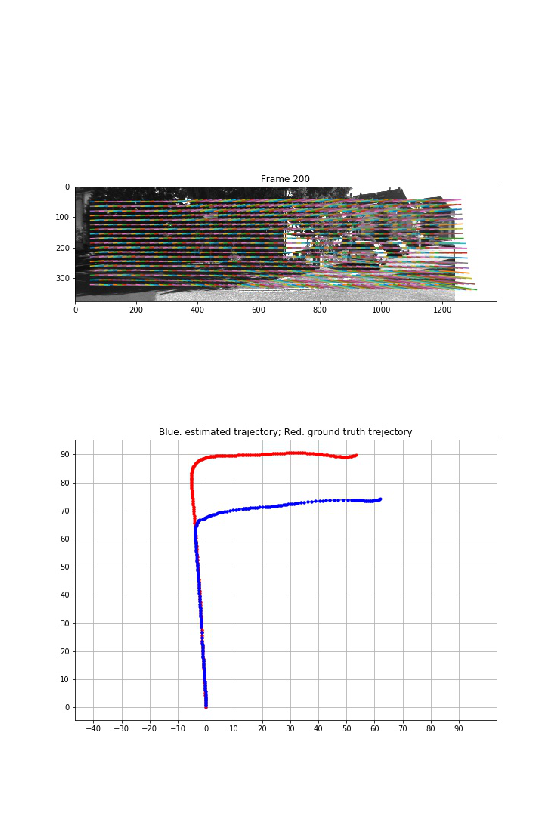

(1463, 4)
[[ 0.3906  0.0237  0.9202 62.4608]
 [ 0.0855  0.9944 -0.0619 -3.8845]
 [-0.9166  0.1028  0.3864 74.4171]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.74677
== [Result] Frame: 201, Matches 1463, Inliers: 99.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame201.jpg
(1463, 4)
[[ 0.4473  0.0236  0.8941 62.7826]
 [ 0.0845  0.9941 -0.0685 -3.9207]
 [-0.8904  0.1062  0.4426 74.6022]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.74369
== [Result] Frame: 202, Matches 1463, Inliers: 97.54


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame202.jpg
(1463, 4)
[[ 0.5039  0.0273  0.8634 63.0741]
 [ 0.0805  0.9937 -0.0784 -3.9585]
 [-0.86    0.109   0.4985 74.8195]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.74060
== [Result] Frame: 203, Matches 1463, Inliers: 98.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame203.jpg
(1463, 4)
[[ 0.5619  0.0292  0.8267 63.3544]
 [ 0.0791  0.9929 -0.0889 -3.9974]
 [-0.8234  0.1154  0.5556 75.0341]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.73760
== [Result] Frame: 204, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame204.jpg
(1463, 4)
[[ 0.6145  0.0349  0.7881 63.5807]
 [ 0.0689  0.9928 -0.0977 -4.0387]
 [-0.7859  0.1144  0.6077 75.2973]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.73466
== [Result] Frame: 205, Matches 1463, Inliers: 94.33


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame205.jpg
(1463, 4)
[[ 0.6659  0.0383  0.7451 63.807 ]
 [ 0.0598  0.9927 -0.1045 -4.0817]
 [-0.7437  0.1141  0.6587 75.5802]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.73171
== [Result] Frame: 206, Matches 1463, Inliers: 96.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame206.jpg
(1463, 4)
[[ 0.7138  0.041   0.6991 64.014 ]
 [ 0.0509  0.9926 -0.1102 -4.1276]
 [-0.6984  0.1143  0.7065 75.8914]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.72877
== [Result] Frame: 207, Matches 1463, Inliers: 91.18


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame207.jpg
(1463, 4)
[[ 0.7574  0.0426  0.6516 64.189 ]
 [ 0.0417  0.9927 -0.1134 -4.1782]
 [-0.6516  0.1131  0.75   76.2279]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.72583
== [Result] Frame: 208, Matches 1463, Inliers: 92.89


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame208.jpg
(1463, 4)
[[ 0.7976  0.0407  0.6019 66.1316]
 [ 0.0335  0.9932 -0.1115 -4.7867]
 [-0.6023  0.1091  0.7908 80.6336]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.74335
== [Result] Frame: 209, Matches 1463, Inliers: 88.52


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame209.jpg
(1463, 4)
[[ 0.836   0.0336  0.5477 66.2832]
 [ 0.0298  0.9939 -0.1064 -4.8301]
 [-0.5479  0.1053  0.8299 80.9406]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.74047
== [Result] Frame: 210, Matches 1463, Inliers: 86.53


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame210.jpg
(1463, 4)
[[ 0.8682  0.0365  0.4948 66.3743]
 [ 0.0177  0.9944 -0.1043 -4.8616]
 [-0.4958  0.0994  0.8627 81.2653]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.73764
== [Result] Frame: 211, Matches 1463, Inliers: 84.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame211.jpg
(1463, 4)
[[ 0.8958  0.0361  0.443  66.4526]
 [ 0.0092  0.995  -0.0996 -4.8961]
 [-0.4443  0.0933  0.891  81.5668]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00368
Mean Error Translation: 0.73501
== [Result] Frame: 212, Matches 1463, Inliers: 92.55


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame212.jpg
(1463, 4)
[[ 0.918   0.041   0.3943 66.5454]
 [-0.0029  0.9953 -0.0968 -4.9397]
 [-0.3965  0.0877  0.9139 81.9789]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00369
Mean Error Translation: 0.73197
== [Result] Frame: 213, Matches 1463, Inliers: 98.91


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame213.jpg
(1463, 4)
[[ 0.936   0.0442  0.3492 66.6363]
 [-0.0118  0.9955 -0.0945 -4.9819]
 [-0.3518  0.0843  0.9323 82.3597]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00369
Mean Error Translation: 0.72896
== [Result] Frame: 214, Matches 1463, Inliers: 98.63


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame214.jpg
(1463, 4)
[[ 0.9493  0.05    0.3103 66.7168]
 [-0.0224  0.9955 -0.0917 -5.035 ]
 [-0.3135  0.0801  0.9462 82.7762]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00368
Mean Error Translation: 0.72596
== [Result] Frame: 215, Matches 1463, Inliers: 95.97


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame215.jpg
(1463, 4)
[[ 0.9599  0.0535  0.2752 66.7939]
 [-0.0289  0.9953 -0.0927 -5.0754]
 [-0.2788  0.081   0.9569 83.1607]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.72303
== [Result] Frame: 216, Matches 1463, Inliers: 99.52


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame216.jpg
(1463, 4)
[[ 0.9677  0.0581  0.2452 66.86  ]
 [-0.0362  0.995  -0.093  -5.1115]
 [-0.2494  0.0811  0.965  83.5564]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.72015
== [Result] Frame: 217, Matches 1463, Inliers: 99.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame217.jpg
(1463, 4)
[[ 0.9731  0.0546  0.2236 66.9339]
 [-0.0345  0.9951 -0.0929 -5.1514]
 [-0.2276  0.0827  0.9702 83.9498]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00368
Mean Error Translation: 0.71731
== [Result] Frame: 218, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame218.jpg
(1463, 4)
[[ 0.9766  0.0526  0.2083 67.0312]
 [-0.0339  0.9952 -0.0921 -5.2099]
 [-0.2122  0.0829  0.9737 84.4848]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.71435
== [Result] Frame: 219, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame219.jpg
(1463, 4)
[[ 0.9791  0.0563  0.1954 67.1433]
 [-0.0388  0.995  -0.0924 -5.2743]
 [-0.1996  0.0829  0.9764 85.1262]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.71180
== [Result] Frame: 220, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame220.jpg
(1463, 4)
[[ 0.9811  0.0588  0.1846 67.2719]
 [-0.0424  0.9949 -0.0912 -5.3486]
 [-0.189   0.0816  0.9786 85.8372]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.70956
== [Result] Frame: 221, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame221.jpg
(1463, 4)
[[ 0.982   0.064   0.1778 67.4014]
 [-0.0482  0.9946 -0.0918 -5.4318]
 [-0.1827  0.0816  0.9798 86.6141]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.70759
== [Result] Frame: 222, Matches 1463, Inliers: 99.11


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame222.jpg
(1463, 4)
[[ 0.9824  0.0677  0.1743 67.5429]
 [-0.0516  0.9941 -0.095  -5.5298]
 [-0.1797  0.0843  0.9801 87.4868]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.70602
== [Result] Frame: 223, Matches 1463, Inliers: 97.74


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame223.jpg
(1463, 4)
[[ 0.9825  0.0675  0.1733 67.7042]
 [-0.0511  0.994  -0.0971 -5.6438]
 [-0.1788  0.0865  0.9801 88.4084]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.70466
== [Result] Frame: 224, Matches 1463, Inliers: 96.65


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame224.jpg
(1463, 4)
[[ 0.9822  0.0655  0.176  67.8813]
 [-0.0483  0.9938 -0.1003 -5.7594]
 [-0.1814  0.0901  0.9793 89.3873]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.70353
== [Result] Frame: 225, Matches 1463, Inliers: 95.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame225.jpg
(1463, 4)
[[ 0.9814  0.0651  0.1807 68.0484]
 [-0.0463  0.9932 -0.1068 -5.8684]
 [-0.1864  0.0964  0.9777 90.4199]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.70260
== [Result] Frame: 226, Matches 1463, Inliers: 96.31


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame226.jpg
(1463, 4)
[[ 0.9805  0.064   0.1858 68.19  ]
 [-0.0436  0.9928 -0.1116 -5.9564]
 [-0.1916  0.1013  0.9762 91.2682]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.70081
== [Result] Frame: 227, Matches 1463, Inliers: 96.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame227.jpg
(1463, 4)
[[ 0.9798  0.0684  0.1879 68.3404]
 [-0.0481  0.9927 -0.1104 -6.0402]
 [-0.1941  0.0992  0.976  91.9026]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.69809
== [Result] Frame: 228, Matches 1463, Inliers: 95.35


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame228.jpg
(1463, 4)
[[ 0.9784  0.0698  0.1944 68.4165]
 [-0.0497  0.9931 -0.1062 -6.0908]
 [-0.2005  0.0943  0.9751 92.3425]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.69576
== [Result] Frame: 229, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame229.jpg
(1463, 4)
[[ 0.9777  0.0678  0.199  68.5061]
 [-0.0482  0.9936 -0.1018 -6.1386]
 [-0.2046  0.0899  0.9747 92.769 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.69356
== [Result] Frame: 230, Matches 1463, Inliers: 99.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame230.jpg
(1463, 4)
[[ 0.9768  0.0652  0.2042 68.5911]
 [-0.0463  0.9943 -0.0957 -6.1929]
 [-0.2093  0.0841  0.9742 93.2322]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.69129
== [Result] Frame: 231, Matches 1463, Inliers: 97.47


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame231.jpg
(1463, 4)
[[ 0.976   0.0639  0.2083 68.6851]
 [-0.0458  0.9949 -0.0903 -6.2493]
 [-0.213   0.0786  0.9739 93.6923]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00361
Mean Error Translation: 0.68910
== [Result] Frame: 232, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame232.jpg
(1463, 4)
[[ 0.9751  0.0626  0.2128 68.7795]
 [-0.0443  0.995  -0.0896 -6.3018]
 [-0.2174  0.078   0.973  94.2006]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.68677
== [Result] Frame: 233, Matches 1463, Inliers: 99.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame233.jpg
(1463, 4)
[[ 0.9749  0.0613  0.2142 68.9285]
 [-0.0423  0.9948 -0.0922 -6.3842]
 [-0.2188  0.0809  0.9724 94.9473]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 0.68438
== [Result] Frame: 234, Matches 1463, Inliers: 95.35


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame234.jpg
(1463, 4)
[[ 0.9746  0.0635  0.2148 69.0955]
 [-0.0429  0.9941 -0.0991 -6.4761]
 [-0.2199  0.0874  0.9716 95.82  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 0.68248
== [Result] Frame: 235, Matches 1463, Inliers: 96.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame235.jpg
(1463, 4)
[[ 0.974   0.0692  0.2155 69.274 ]
 [-0.0472  0.9933 -0.1059 -6.5808]
 [-0.2214  0.093   0.9707 96.8429]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.68118
== [Result] Frame: 236, Matches 1463, Inliers: 96.99


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame236.jpg
(1463, 4)
[[ 0.9738  0.0755  0.2143 69.463 ]
 [-0.0527  0.9925 -0.11   -6.6889]
 [-0.221   0.0958  0.9706 97.9405]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.68014
== [Result] Frame: 237, Matches 1463, Inliers: 94.05


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame237.jpg
(1463, 4)
[[ 0.9744  0.0754  0.212  69.7065]
 [-0.0538  0.993  -0.1055 -6.8154]
 [-0.2185  0.0914  0.9715 99.0542]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.67912
== [Result] Frame: 238, Matches 1463, Inliers: 88.72


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame238.jpg
(1463, 4)
[[  0.9746   0.0734   0.2114  69.9369]
 [ -0.0535   0.9937  -0.0981  -6.9333]
 [ -0.2173   0.0843   0.9725 100.1504]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.67797
== [Result] Frame: 239, Matches 1463, Inliers: 88.11


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame239.jpg
(1463, 4)
[[  0.9742   0.0789   0.2117  70.1042]
 [ -0.0605   0.9939  -0.0921  -7.0593]
 [ -0.2176   0.0769   0.973  101.1943]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.67656
== [Result] Frame: 240, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame240.jpg
(1463, 4)
[[  0.9741   0.0838   0.2102  70.3287]
 [ -0.0656   0.9936  -0.0922  -7.1929]
 [ -0.2166   0.076    0.9733 102.3443]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.67559
== [Result] Frame: 241, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame241.jpg
(1463, 4)
[[  0.9742   0.0886   0.2076  70.5528]
 [ -0.0698   0.9929  -0.0961  -7.3157]
 [ -0.2147   0.0791   0.9735 103.4416]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.67438
== [Result] Frame: 242, Matches 1463, Inliers: 96.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame242.jpg
(1463, 4)
[[  0.9745   0.0908   0.2053  70.7755]
 [ -0.0711   0.9923  -0.1012  -7.455 ]
 [ -0.2129   0.084    0.9735 104.767 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.67407
== [Result] Frame: 243, Matches 1463, Inliers: 92.75


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame243.jpg
(1463, 4)
[[  0.9747   0.0923   0.2034  71.0094]
 [ -0.0722   0.9919  -0.1042  -7.5977]
 [ -0.2114   0.0869   0.9735 106.1789]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.67406
== [Result] Frame: 244, Matches 1463, Inliers: 93.44


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame244.jpg
(1463, 4)
[[  0.976    0.0886   0.1987  71.2722]
 [ -0.0692   0.9923  -0.1025  -7.7275]
 [ -0.2063   0.0863   0.9747 107.3598]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.67307
== [Result] Frame: 245, Matches 1463, Inliers: 88.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame245.jpg
(1463, 4)
[[  0.9765   0.088    0.1966  71.4439]
 [ -0.0693   0.9926  -0.0999  -7.8514]
 [ -0.2039   0.0839   0.9754 108.3704]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.67136
== [Result] Frame: 246, Matches 1463, Inliers: 87.76


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame246.jpg
(1463, 4)
[[  0.977    0.0866   0.1949  71.6621]
 [ -0.0687   0.9929  -0.0967  -7.9809]
 [ -0.2019   0.0811   0.976  109.4655]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.66994
== [Result] Frame: 247, Matches 1463, Inliers: 87.15


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame247.jpg
(1463, 4)
[[  0.9779   0.0804   0.193   71.9218]
 [ -0.0632   0.9936  -0.0937  -8.1192]
 [ -0.1993   0.0794   0.9767 110.6889]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.66899
== [Result] Frame: 248, Matches 1463, Inliers: 92.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame248.jpg
(1463, 4)
[[  0.9784   0.0745   0.1929  72.2092]
 [ -0.0577   0.9941  -0.0917  -8.283 ]
 [ -0.1986   0.0786   0.9769 112.1378]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.66896
== [Result] Frame: 249, Matches 1463, Inliers: 87.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame249.jpg
(1463, 4)
[[  0.9792   0.0707   0.1902  72.595 ]
 [ -0.0543   0.9945  -0.0901  -8.4501]
 [ -0.1955   0.0779   0.9776 113.8236]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.66988
== [Result] Frame: 250, Matches 1463, Inliers: 89.75


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame250.jpg


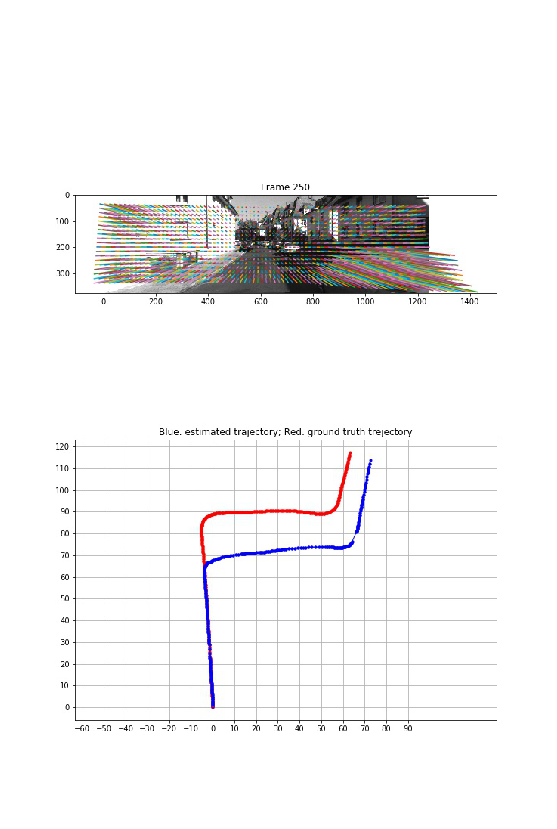

(1463, 4)
[[  0.9793   0.0725   0.1891  72.9561]
 [ -0.0559   0.9942  -0.0918  -8.637 ]
 [ -0.1947   0.0793   0.9777 115.4931]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.67073
== [Result] Frame: 251, Matches 1463, Inliers: 85.71


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame251.jpg
(1463, 4)
[[  0.9784   0.0803   0.1904  73.0489]
 [ -0.0631   0.9935  -0.0949  -8.6973]
 [ -0.1968   0.0809   0.9771 116.0696]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.66911
== [Result] Frame: 252, Matches 1463, Inliers: 89.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame252.jpg
(1463, 4)
[[  0.9776   0.089    0.1907  73.1549]
 [ -0.0716   0.9928  -0.0964  -8.7568]
 [ -0.1979   0.0806   0.9769 116.6399]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00364
Mean Error Translation: 0.66754
== [Result] Frame: 253, Matches 1463, Inliers: 92.96


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame253.jpg
(1463, 4)
[[  0.9767   0.0927   0.1934  73.268 ]
 [ -0.0753   0.9926  -0.0955  -8.8228]
 [ -0.2008   0.0787   0.9765 117.2233]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00365
Mean Error Translation: 0.66594
== [Result] Frame: 254, Matches 1463, Inliers: 99.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame254.jpg
(1463, 4)
[[  0.9767   0.0906   0.1947  73.408 ]
 [ -0.0734   0.9929  -0.0937  -8.8916]
 [ -0.2018   0.0773   0.9764 117.8222]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.66430
== [Result] Frame: 255, Matches 1463, Inliers: 94.12


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame255.jpg
(1463, 4)
[[  0.9764   0.0883   0.1969  73.5328]
 [ -0.0707   0.993   -0.0945  -8.9579]
 [ -0.2039   0.0783   0.9759 118.4177]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.66270
== [Result] Frame: 256, Matches 1463, Inliers: 98.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame256.jpg
(1463, 4)
[[  0.9761   0.0865   0.1993  73.647 ]
 [ -0.0682   0.9929  -0.097   -9.0238]
 [ -0.2063   0.0811   0.9751 119.0141]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.66114
== [Result] Frame: 257, Matches 1463, Inliers: 99.11


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame257.jpg
(1463, 4)
[[  0.9768   0.0767   0.2001  73.7846]
 [ -0.0585   0.9937  -0.0952  -9.0952]
 [ -0.2062   0.0813   0.9751 119.6014]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.65966
== [Result] Frame: 258, Matches 1463, Inliers: 97.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame258.jpg
(1463, 4)
[[  0.9778   0.0662   0.1988  73.9329]
 [ -0.0478   0.9942  -0.0962  -9.1702]
 [ -0.2041   0.0846   0.9753 120.1889]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.65816
== [Result] Frame: 259, Matches 1463, Inliers: 93.37


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame259.jpg
(1463, 4)
[[  0.9773   0.0658   0.2012  74.049 ]
 [ -0.0473   0.9943  -0.0955  -9.2455]
 [ -0.2063   0.0838   0.9749 120.7886]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00367
Mean Error Translation: 0.65665
== [Result] Frame: 260, Matches 1463, Inliers: 89.68


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame260.jpg
(1463, 4)
[[  0.9765   0.0689   0.204   74.1656]
 [ -0.0508   0.9944  -0.0929  -9.3098]
 [ -0.2093   0.0803   0.9746 121.408 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.65508
== [Result] Frame: 261, Matches 1463, Inliers: 93.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame261.jpg
(1463, 4)
[[  0.9759   0.071    0.2062  74.2879]
 [ -0.0541   0.9948  -0.0864  -9.3835]
 [ -0.2113   0.0732   0.9747 122.0511]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.65344
== [Result] Frame: 262, Matches 1463, Inliers: 92.21


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame262.jpg
(1463, 4)
[[  0.9755   0.0733   0.2075  74.4259]
 [ -0.0572   0.995   -0.0823  -9.4531]
 [ -0.2125   0.0684   0.9748 122.7197]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.65168
== [Result] Frame: 263, Matches 1463, Inliers: 95.08


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame263.jpg
(1463, 4)
[[  0.9759   0.0695   0.2071  74.5853]
 [ -0.0519   0.9947  -0.089   -9.5257]
 [ -0.2122   0.076    0.9743 123.4054]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00366
Mean Error Translation: 0.64977
== [Result] Frame: 264, Matches 1463, Inliers: 94.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame264.jpg
(1463, 4)
[[  0.9769   0.0608   0.2047  74.7995]
 [ -0.0402   0.9938  -0.1032  -9.6214]
 [ -0.2097   0.0926   0.9734 124.2398]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00368
Mean Error Translation: 0.64753
== [Result] Frame: 265, Matches 1463, Inliers: 91.87


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame265.jpg
(1463, 4)
[[  0.9779   0.0551   0.2016  75.0577]
 [ -0.0329   0.9931  -0.1122  -9.7351]
 [ -0.2064   0.1031   0.973  125.2407]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00368
Mean Error Translation: 0.64587
== [Result] Frame: 266, Matches 1463, Inliers: 93.10


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame266.jpg
(1463, 4)
[[  0.9781   0.052    0.2017  75.2639]
 [ -0.0317   0.9942  -0.1027  -9.8574]
 [ -0.2059   0.0941   0.974  126.2759]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00369
Mean Error Translation: 0.64429
== [Result] Frame: 267, Matches 1463, Inliers: 92.48


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame267.jpg
(1463, 4)
[[  0.9788   0.0429   0.2004  75.5293]
 [ -0.0268   0.9962  -0.0823  -9.99  ]
 [ -0.2032   0.0752   0.9763 127.4698]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00370
Mean Error Translation: 0.64326
== [Result] Frame: 268, Matches 1463, Inliers: 89.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame268.jpg
(1463, 4)
[[  0.9787   0.0409   0.201   75.7946]
 [ -0.0278   0.9973  -0.0673 -10.1516]
 [ -0.2032   0.0603   0.9773 128.8772]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00371
Mean Error Translation: 0.64305
== [Result] Frame: 269, Matches 1463, Inliers: 84.14


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame269.jpg
(1463, 4)
[[  0.9781   0.05     0.202   76.0259]
 [ -0.0358   0.9967  -0.0731 -10.2986]
 [ -0.205    0.0643   0.9766 130.342 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.64315
== [Result] Frame: 270, Matches 1463, Inliers: 90.50


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame270.jpg
(1463, 4)
[[  0.9784   0.0557   0.1991  76.1602]
 [ -0.0385   0.9953  -0.0893 -10.3578]
 [ -0.2031   0.0797   0.9759 131.0052]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.64133
== [Result] Frame: 271, Matches 1463, Inliers: 92.41


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame271.jpg
(1463, 4)
[[  0.9782   0.0578   0.1995  76.2671]
 [ -0.0392   0.9946  -0.0964 -10.4297]
 [ -0.204    0.0865   0.9751 131.6532]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.63966
== [Result] Frame: 272, Matches 1463, Inliers: 87.42


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame272.jpg
(1463, 4)
[[  0.9784   0.0561   0.1991  76.3735]
 [ -0.0372   0.9945  -0.0975 -10.4936]
 [ -0.2034   0.088    0.9751 132.2779]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.63808
== [Result] Frame: 273, Matches 1463, Inliers: 96.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame273.jpg
(1463, 4)
[[  0.9789   0.0548   0.197   76.4895]
 [ -0.0364   0.9948  -0.0956 -10.567 ]
 [ -0.2012   0.0864   0.9757 132.8981]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.63651
== [Result] Frame: 274, Matches 1463, Inliers: 99.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame274.jpg
(1463, 4)
[[  0.9795   0.0541   0.1941  76.6075]
 [ -0.0358   0.9947  -0.0965 -10.6384]
 [ -0.1983   0.0876   0.9762 133.5606]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.63478
== [Result] Frame: 275, Matches 1463, Inliers: 99.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame275.jpg
(1463, 4)
[[  0.9801   0.0557   0.1904  76.7741]
 [ -0.0375   0.9945  -0.098  -10.7451]
 [ -0.1948   0.089    0.9768 134.5407]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.63323
== [Result] Frame: 276, Matches 1463, Inliers: 97.27


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame276.jpg
(1463, 4)
[[  0.9807   0.057    0.187   76.9833]
 [ -0.0391   0.9944  -0.0979 -10.8793]
 [ -0.1915   0.0887   0.9775 135.6294]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.63201
== [Result] Frame: 277, Matches 1463, Inliers: 90.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame277.jpg
(1463, 4)
[[  0.9812   0.0589   0.1838  77.1965]
 [ -0.0413   0.9943  -0.0981 -11.0072]
 [ -0.1885   0.0887   0.9781 136.7426]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00374
Mean Error Translation: 0.63099
== [Result] Frame: 278, Matches 1463, Inliers: 85.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame278.jpg
(1463, 4)
[[  0.9819   0.0563   0.1807  77.4309]
 [ -0.0393   0.9945  -0.0967 -11.1339]
 [ -0.1852   0.0878   0.9788 137.9216]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.63014
== [Result] Frame: 279, Matches 1463, Inliers: 86.19


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame279.jpg
(1463, 4)
[[  0.9819   0.0555   0.1813  77.5806]
 [ -0.0393   0.995   -0.0918 -11.2449]
 [ -0.1855   0.083    0.9791 138.9096]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.62863
== [Result] Frame: 280, Matches 1463, Inliers: 93.71


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame280.jpg
(1463, 4)
[[  0.9817   0.056    0.1821  77.736 ]
 [ -0.0398   0.995   -0.0917 -11.3669]
 [ -0.1863   0.0827   0.979  139.988 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.62746
== [Result] Frame: 281, Matches 1463, Inliers: 91.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame281.jpg
(1463, 4)
[[  0.9822   0.055    0.1795  77.9372]
 [ -0.0384   0.9948  -0.0948 -11.4894]
 [ -0.1838   0.0862   0.9792 141.1169]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00374
Mean Error Translation: 0.62649
== [Result] Frame: 282, Matches 1463, Inliers: 93.44


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame282.jpg
(1463, 4)
[[  0.9828   0.0564   0.176   78.1104]
 [ -0.0394   0.9944  -0.0985 -11.6088]
 [ -0.1805   0.0899   0.9795 142.249 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00376
Mean Error Translation: 0.62555
== [Result] Frame: 283, Matches 1463, Inliers: 86.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame283.jpg
(1463, 4)
[[  0.984    0.0535   0.1702  78.3257]
 [ -0.037    0.9944  -0.0985 -11.7606]
 [ -0.1745   0.0906   0.9805 143.5773]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.62528
== [Result] Frame: 284, Matches 1463, Inliers: 81.13


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame284.jpg
(1463, 4)
[[  0.9854   0.0469   0.1634  78.5784]
 [ -0.0319   0.9952  -0.093  -11.917 ]
 [ -0.1669   0.0865   0.9822 144.9672]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.62523
== [Result] Frame: 285, Matches 1463, Inliers: 75.67


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame285.jpg
(1463, 4)
[[  0.9864   0.0455   0.1582  78.7776]
 [ -0.0323   0.9959  -0.085  -12.0594]
 [ -0.1614   0.0787   0.9837 146.38  ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00376
Mean Error Translation: 0.62521
== [Result] Frame: 286, Matches 1463, Inliers: 76.08


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame286.jpg
(1463, 4)
[[  0.9869   0.0425   0.1556  78.9827]
 [ -0.031    0.9966  -0.0759 -12.1982]
 [ -0.1583   0.0701   0.9849 147.8296]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00376
Mean Error Translation: 0.62532
== [Result] Frame: 287, Matches 1463, Inliers: 84.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame287.jpg
(1463, 4)
[[  0.9874   0.0465   0.1512  79.2187]
 [ -0.0357   0.9967  -0.0732 -12.3555]
 [ -0.1541   0.0669   0.9858 149.4584]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00376
Mean Error Translation: 0.62609
== [Result] Frame: 288, Matches 1463, Inliers: 82.30


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame288.jpg
(1463, 4)
[[  0.9879   0.0495   0.1469  79.2956]
 [ -0.0383   0.9962  -0.0778 -12.4131]
 [ -0.1502   0.0713   0.9861 150.0929]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.62451
== [Result] Frame: 289, Matches 1463, Inliers: 90.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame289.jpg
(1463, 4)
[[  0.9883   0.0556   0.1423  79.3428]
 [ -0.0432   0.9951  -0.089  -12.4593]
 [ -0.1465   0.0818   0.9858 150.682 ]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.62309
== [Result] Frame: 290, Matches 1463, Inliers: 95.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame290.jpg
(1463, 4)
[[  0.9891   0.054    0.1368  79.4083]
 [ -0.0412   0.9947  -0.0943 -12.5108]
 [ -0.1412   0.0877   0.9861 151.2591]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.62174
== [Result] Frame: 291, Matches 1463, Inliers: 92.96


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame291.jpg
(1463, 4)
[[  0.9901   0.0515   0.1307  79.4787]
 [ -0.0395   0.9949  -0.0931 -12.5696]
 [ -0.1349   0.087    0.987  151.8408]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.62041
== [Result] Frame: 292, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame292.jpg
(1463, 4)
[[  0.9908   0.056    0.123   79.5462]
 [ -0.0451   0.995   -0.0894 -12.6335]
 [ -0.1274   0.083    0.9884 152.4242]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.61910
== [Result] Frame: 293, Matches 1463, Inliers: 96.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame293.jpg
(1463, 4)
[[  0.9917   0.0584   0.1149  79.6061]
 [ -0.0481   0.9947  -0.0906 -12.6965]
 [ -0.1196   0.0843   0.9892 153.0082]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.61778
== [Result] Frame: 294, Matches 1463, Inliers: 98.63


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame294.jpg
(1463, 4)
[[  0.9923   0.0626   0.1067  79.6428]
 [ -0.0522   0.9939  -0.0976 -12.7468]
 [ -0.1121   0.0913   0.9895 153.5846]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.61650
== [Result] Frame: 295, Matches 1463, Inliers: 97.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame295.jpg
(1463, 4)
[[  0.9932   0.0616   0.0991  79.6896]
 [ -0.0516   0.9937  -0.0999 -12.8062]
 [ -0.1047   0.0941   0.99   154.1614]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.61523
== [Result] Frame: 296, Matches 1463, Inliers: 99.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame296.jpg
(1463, 4)
[[  0.994    0.0601   0.0912  79.7421]
 [ -0.0512   0.994   -0.0969 -12.8702]
 [ -0.0965   0.0916   0.9911 154.7611]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00376
Mean Error Translation: 0.61392
== [Result] Frame: 297, Matches 1463, Inliers: 99.11


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame297.jpg
(1463, 4)
[[  0.995    0.0568   0.0818  79.8147]
 [ -0.0495   0.9947  -0.0897 -12.9435]
 [ -0.0864   0.0852   0.9926 155.4104]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00378
Mean Error Translation: 0.61247
== [Result] Frame: 298, Matches 1463, Inliers: 96.24


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame298.jpg
(1463, 4)
[[  0.9958   0.0552   0.0729  79.8763]
 [ -0.049    0.9952  -0.0841 -13.0199]
 [ -0.0772   0.0802   0.9938 156.1687]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00380
Mean Error Translation: 0.61071
== [Result] Frame: 299, Matches 1463, Inliers: 94.60


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame299.jpg


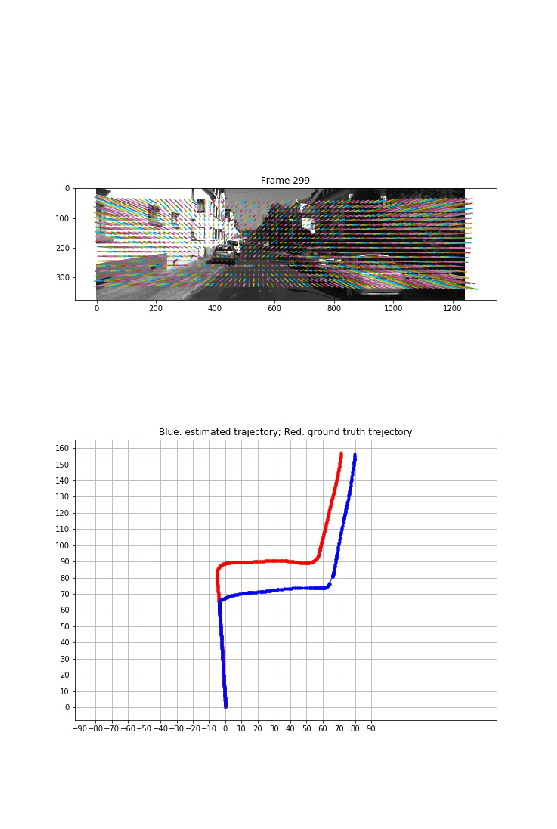

In [6]:
import runMatch
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'Flow'
runMatch.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

The final errors are:

1. Rotation: 0.00380
2. Translation: 0.61071

Next, answer the following questions:

2. Does SPyNet yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, what steps can you take to improve? **(5 points)**

Both the mean-error rotation (0.00380 vs. 0.00277) and translation (0.61071 vs. 0.53721) are worse than the original $\mathtt{libviso2}$. Hence overall the performance of Spynet is worse than the original libviso2. 

One reason for this might be there's large movement in the scene as the Kitti dataset is obtained by driving a car around in the region and the car was moving at a high speed. Hence predicting the optical flow might not be as accurate as the other datasets. 

Another issue could be the brightness constancy in a patch might not hold, as this is an outdoor scene and it could be subject to occlusion and non-lambertian surface.

One way to improve could be interpolating between different frames to augment the dataset and make the movements between each frame smaller.

3. Explain how SPyNet achieves accurate flow with significantly lower computational cost. **(3 points)**

SPNet achieves accurate flow with lower computational cost by using a spatial pyramid structure to predict the residual flow at each level. At each level k, Spynet predicts the residual flow at that level using the warped target image, the reference image, and the up-sampled predicted flow, and add it to the flow from the lower level. The predicted flow at that level is then compared with the down-sampled ground truth flow. 

Predicting the residual flow is a much simpler problem to solve, and requires less complex network achitecture. Hence the overall network architecture of Spynet is much smaller.

## Question 5: Using Sfm-learner for SFM
Now we will use deep neural networks for SFM. Please follow the open-source Sfmlearner repository (https://github.com/ClementPinard/SfmLearner-Pytorch) and the paper (https://people.eecs.berkeley.edu/~tinghuiz/projects/SfMLearner/cvpr17_sfm_final.pdf) to answer the following questions.

1. Describe how photometric loss is implemented in Sfmlearner? Please refer to the paper and the code. **(5 points)**

To calculate the photometric loss, the paper first projects a pixel p in target image $I_t$ to the source image based on the depth and camera pose information. Then bi-linear interpolation is used to get the pixel intensity $\hat{I}_s$. Finally, the loss for this pixel is calculated as $\hat{E}_s(p) \vert \hat{I}_s - I_t(p) \vert$, where $E_s(p)$ is a estimated mask indicating if each target-source pixel-pair could be used for estimating depth and motion, i.e. without occlusion or violating Lambertian assumption.

2. Train the model and show the training curve, validation curve, and visualization of predicted depth and warped images? Which loss is decreasing and which is increasing? Why? **(10 points)**

 Visualize the specific images: `val_Depth_Output_Normalized/0`, `val_Warped_Outputs/0` from tensorboard.
 
 Training data: 
`/datasets/cse152-252-sp20-public/sfmlearner_h128w416`.

#### Install the environment
`pip install -r requirements.txt`
- fix scipy version problem: 

`pip install scipy==1.1.0 --user`

#### Training script
`cd SfmLearner-Pytorch`

`python3 train.py /datasets/cse152-252-sp20-public/sfmlearner_h128w416 -b4 -m0.2 -s0.1 --epoch-size 3000 --sequence-length 3 --log-output`




### Training curves
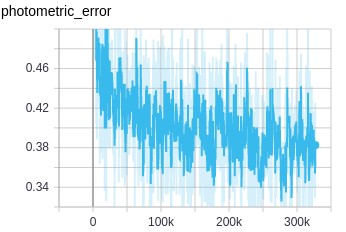

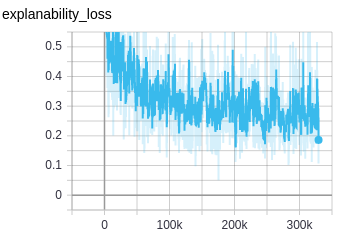

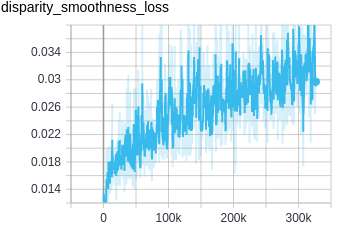

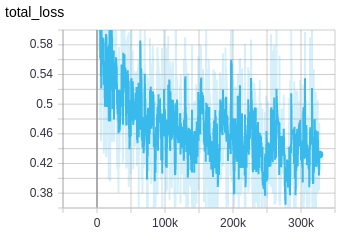

### Validation curves
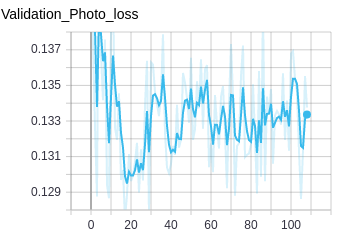

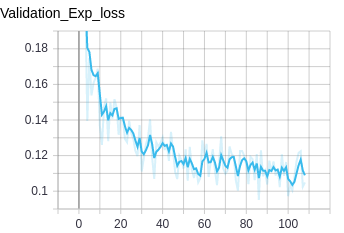

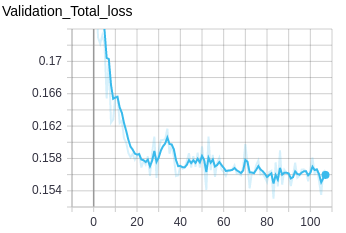

### Depth_output

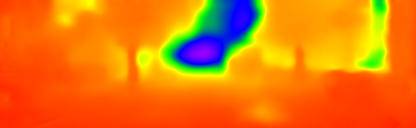

### Warped Image
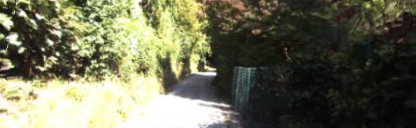

Answer: The photometric loss, explanability mask loss decreased during training, and the smoothness loss increased. The photometric loss and the explanability loss decreased as the network prediction for the motion of camera, as well as the mask prediction become more accurate. The above plots are trained for 108 epochs, with 3000 iterations per each epoch. 

However, the smoothness loss (L1 norm of the second-order gradients for depth map) increased, because from the image we can see that there is a big variability of the depth in the center of the region. Hence the second-order gradient is inevitably large in the center region. Initially, the depth map for the image would be relatively uniform everywhere when the weights are initalized randomly, but as the depth prediction becomes more accurate, the smoothness loss would increase. 


3. When training the model, we use 3 consecutive frames. Now, you will use the photometric consistency between the 1st and the 3rd frame. To be more specific, you can get the pose $T_{1,3} = T_{2,3} @ T_{1,2}$, where $T_{1,2}, T_{2,3}$ have already been computed in the original code. Add the constraint to the total loss and report the results in the same manner as in part 2 above. **(10 points)**

``answer here``

### Training Curve

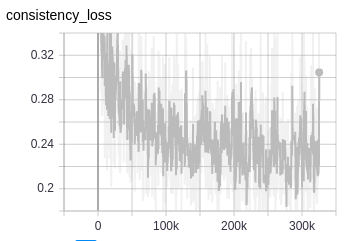

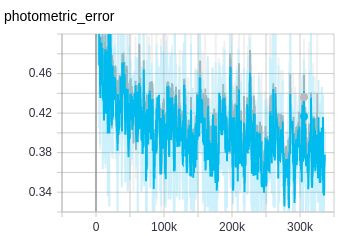

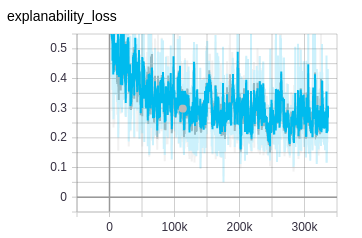

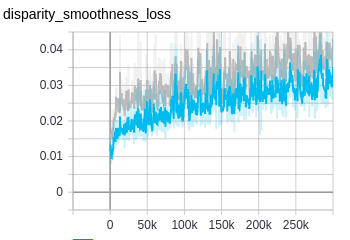

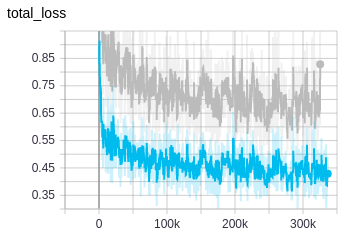

### Validation Curve

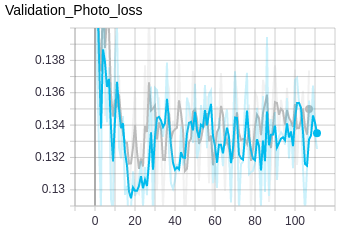

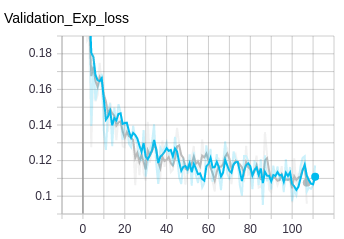

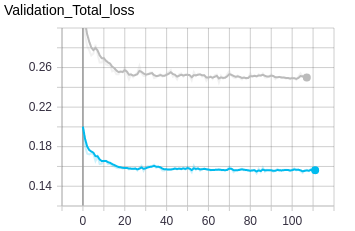

Answer: Similar to part 2), the consistency loss, photometric loss, and explanability mask loss decreased during training. The smoothness loss increased. 

Compared to the training curve and validation curve of part 2), besides a new loss, the smoothness loss) of part 3) is higher than that of part 2). This might be a result of the new loss added is a competing with the smoothness losss.

The consistency loss decreased as the consistency between the first and third frame is better maintained. 

4. Now, you will evaluate your models from parts (2), (3) on the KITTI odometry dataset. What are the error metrics used in Sfm-learner? Please report the `ATE` and `RE` for sequence `09` and `10`. **(5 points)**

  Data: `/datasets/cse152-252-sp20-public/kitti`.

#### Evaluation script
`python3 test_pose.py /path/to/posenet --dataset-dir /datasets/cse152-252-sp20-public/kitti --sequences 09`

The error metrics used in Sfm-learner is ATE (Absolute Trajectory Error) and RE (relative error).

For part 2), using the original loss function, the error metrics on the KITTI dataset are:

Sequence 09:
1. ATE: $0.0141 \pm 0.0079$
2. RE: $0.0024 \pm 0.0012$

Sequence 10:
1. ATE: $0.0104 \pm 0.0077$
2. RE: $0.0025 \pm 0.0017$

For part 3), having added constraint between the 1st and 3rd frame, the error metrics are:

Sequence 09:
1. ATE: $0.0127 \pm 0.0077$
2. RE: $0.0021 \pm  0.0013$

Sequence 10:
1. ATE: $0.0095 \pm 0.0078$
2. RE: $0.0021 \pm 0.0016$

After adding consistency loss and trained for the same number of steps, the ATE and RE of SfmLearner are better on both Kitti 09 and 10 sequences.

### Notes:
- scp data to local machines:

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/sfmlearner_h128w416.zip`

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/kitti.zip`
...
- tensorboard: open jupyter notebook from the link after `launch-scipy-ml-gpu.sh`. Click new `Tensorboard ..`

# References
1. Daniel DeTone, Tomasz Malisiewicz, and Andrew Rabinovich. Superpoint: Self-supervised interest point detection and description. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops, pages 224–236, 2018.
2. Andreas Geiger, Philip Lenz, and Raquel Urtasun. Are we ready for autonomous driving? the kitti vision benchmark suite. In Conference on Computer Vision and Pattern Recognition (CVPR), 2012.
3. Andreas Geiger, Julius Ziegler, and Christoph Stiller. Stereoscan: Dense 3d reconstruction in real-time. In Intelligent Vehicles Symposium (IV), 2011.
4. David G Lowe. Distinctive image features from scale-invariant keypoints. IJCV, 60(2):91–110, 2004.
5. Anurag Ranjan and Michael J Black. Optical flow estimation using a spatial pyramid network. In
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 4161–4170, 2017.
6. A. Vedaldi and B. Fulkerson. VLFeat: An open and portable library of computer vision algorithms. http://www.vlfeat.org/, 2008.
7. Lucas, Bruce D., and Takeo Kanade. "An iterative image registration technique with an application to stereo vision." (1981): 674.
8. B. Kitt, A. Geiger, and H. Lategahn, “Visual odometry based on stereo image sequences with RANSAC-based outlier rejection scheme,” in 2010 IEEE Intelligent Vehicles Symposium, La Jolla, CA, USA, Jun. 2010, pp. 486–492, doi: 10.1109/IVS.2010.5548123.
9. A. Geiger, J. Ziegler, and C. Stiller, “StereoScan: Dense 3d reconstruction in real-time,” in 2011 IEEE Intelligent Vehicles Symposium (IV), Baden-Baden, Germany, Jun. 2011, pp. 963–968, doi: 10.1109/IVS.2011.5940405.